NGTS-10 had a failed observation, do we need to re observe?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/'

In [3]:
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits']

Note oeoo36010 has poor slit alignment

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
528.6959
0.80208945


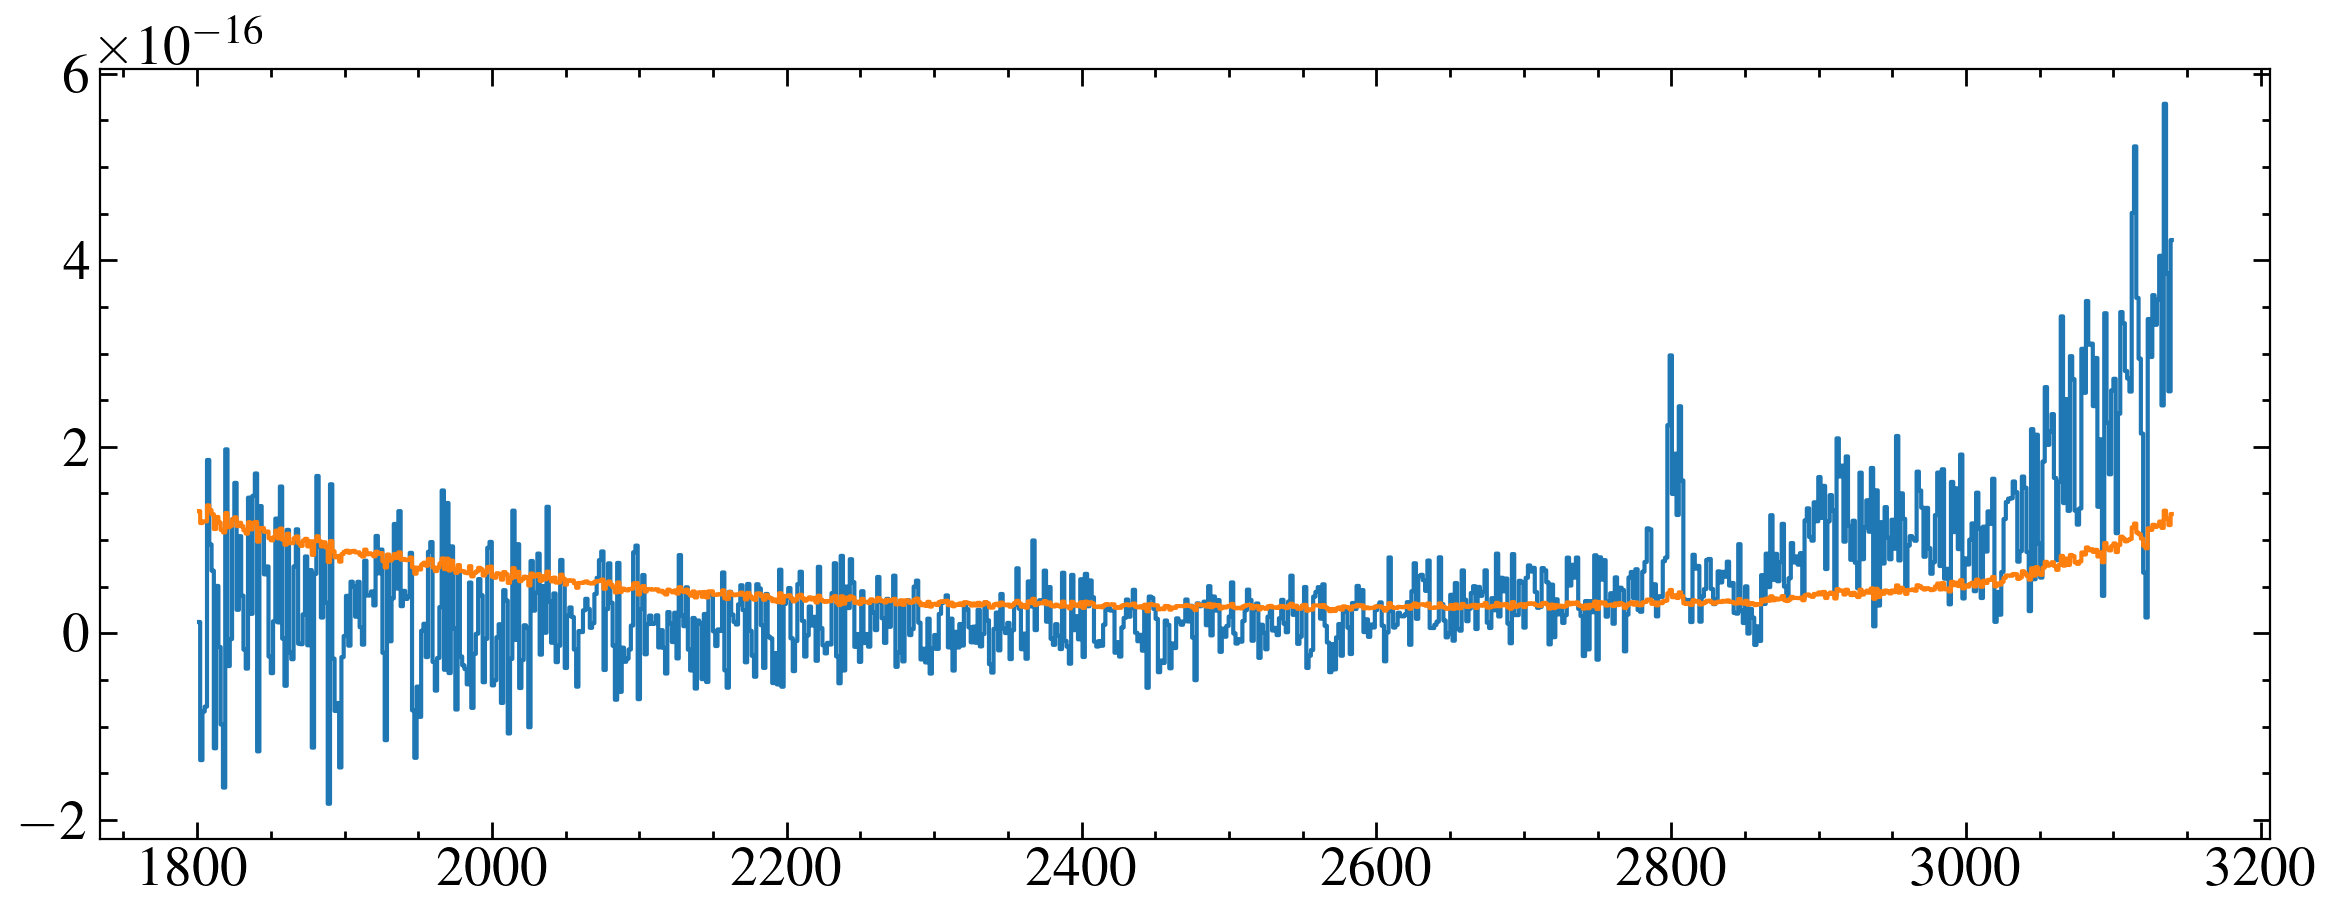

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
528.76044
0.8611564


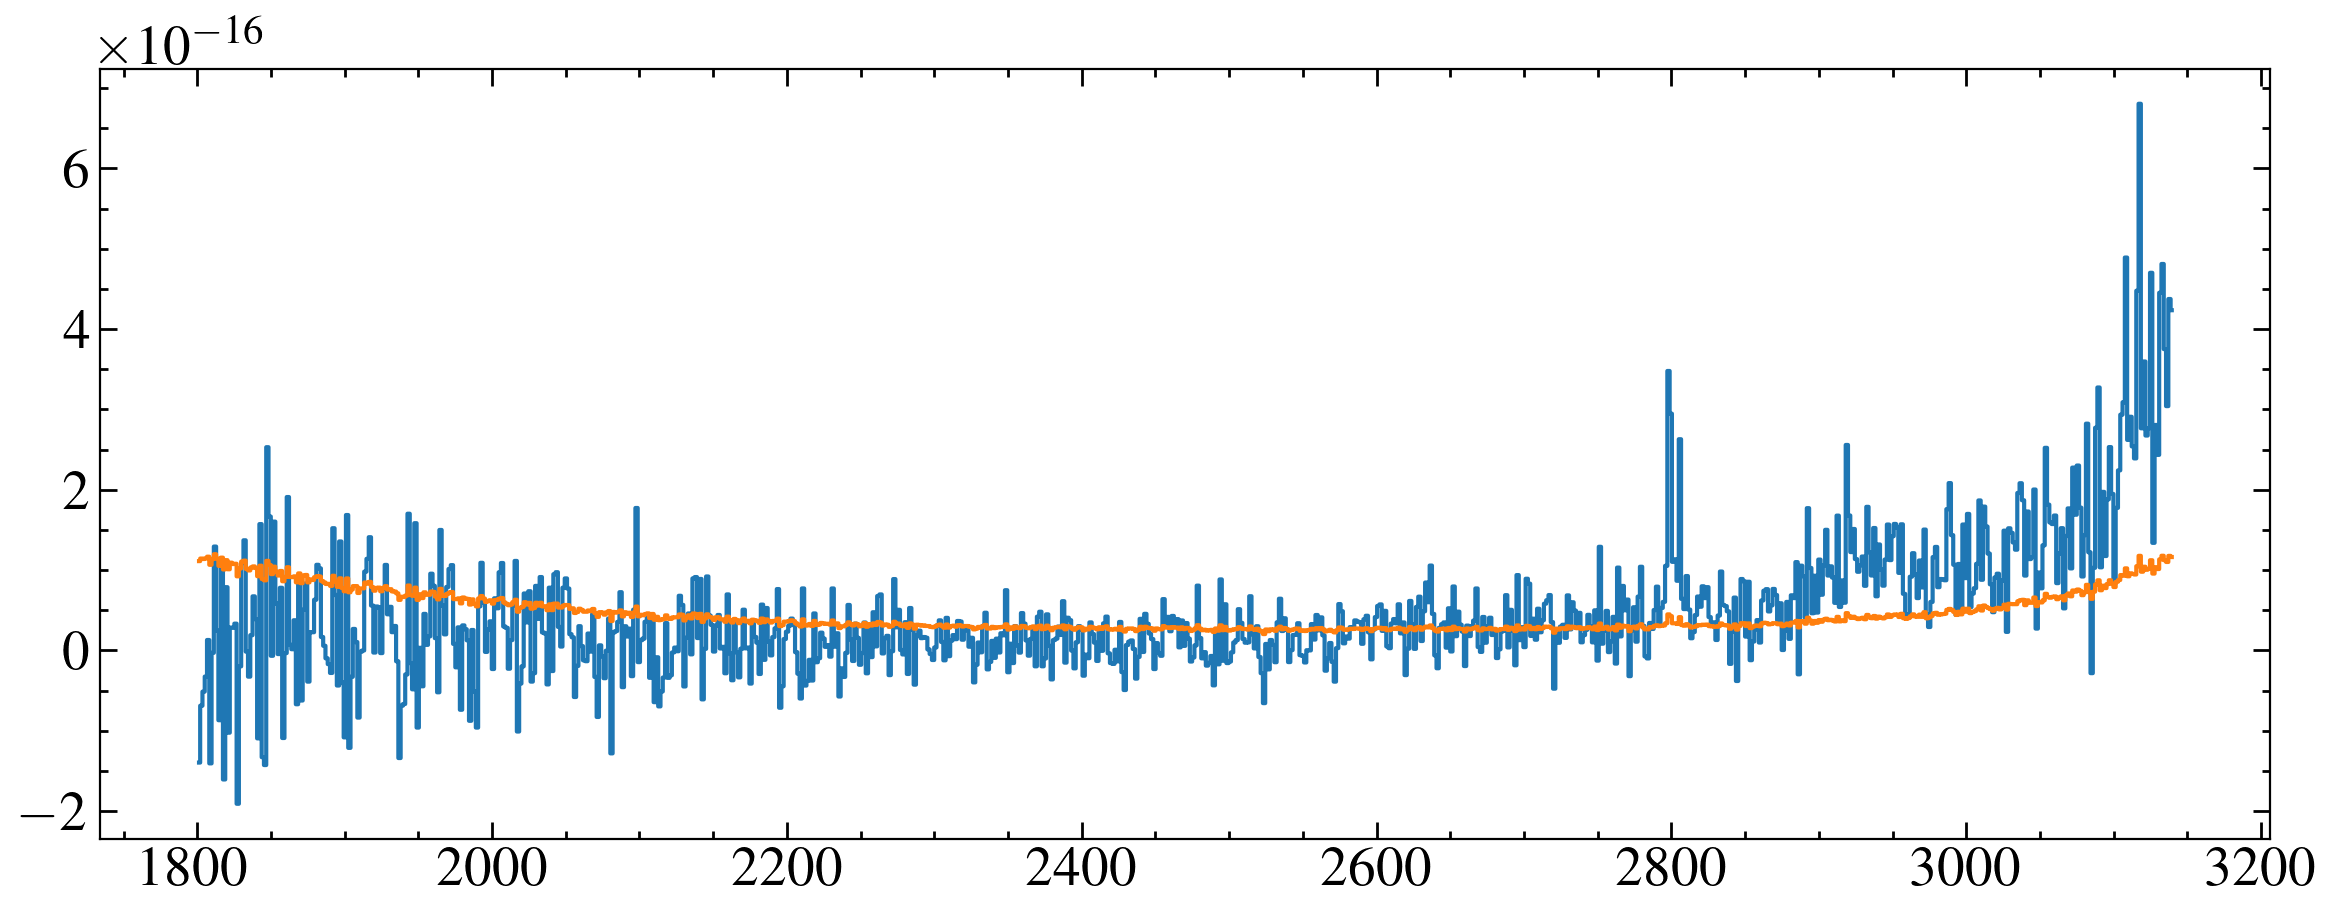

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
528.84503
0.767719


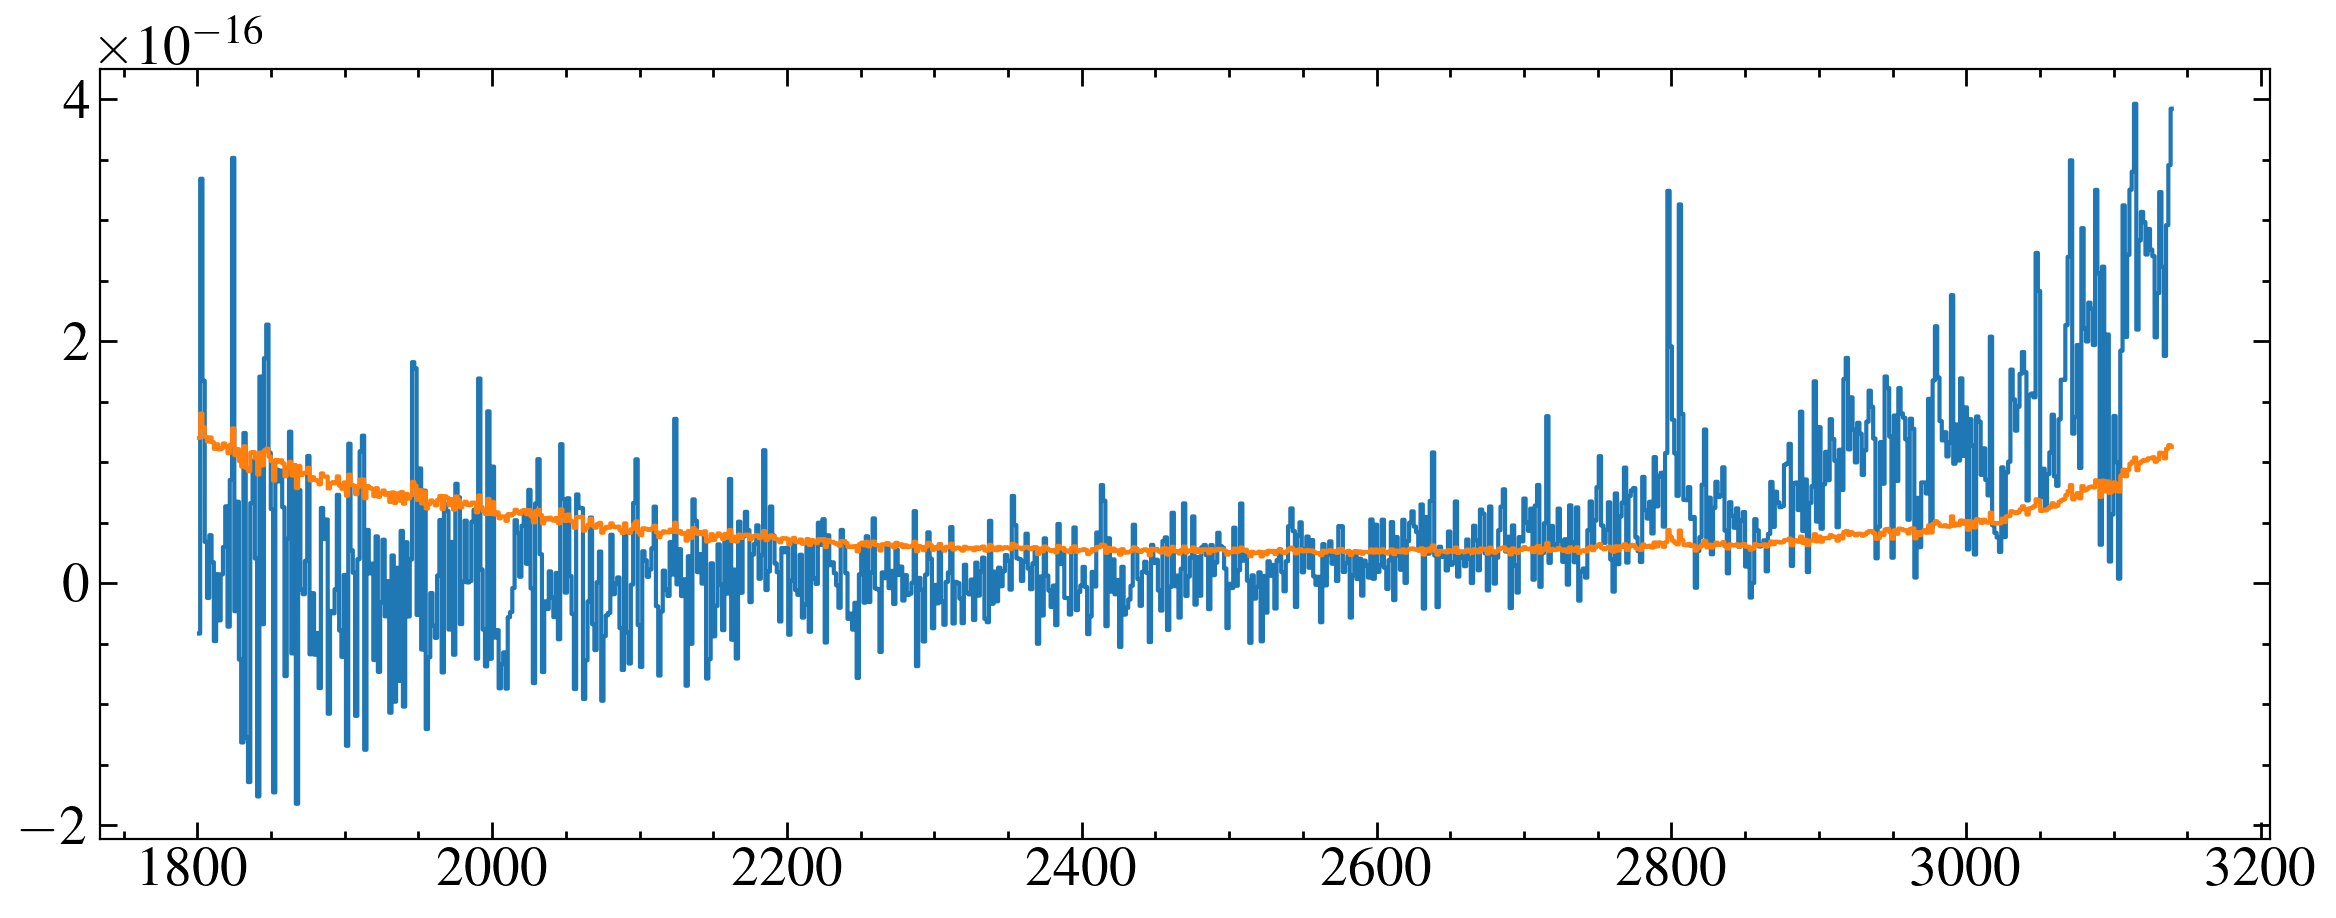

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
528.88574
0.7592693


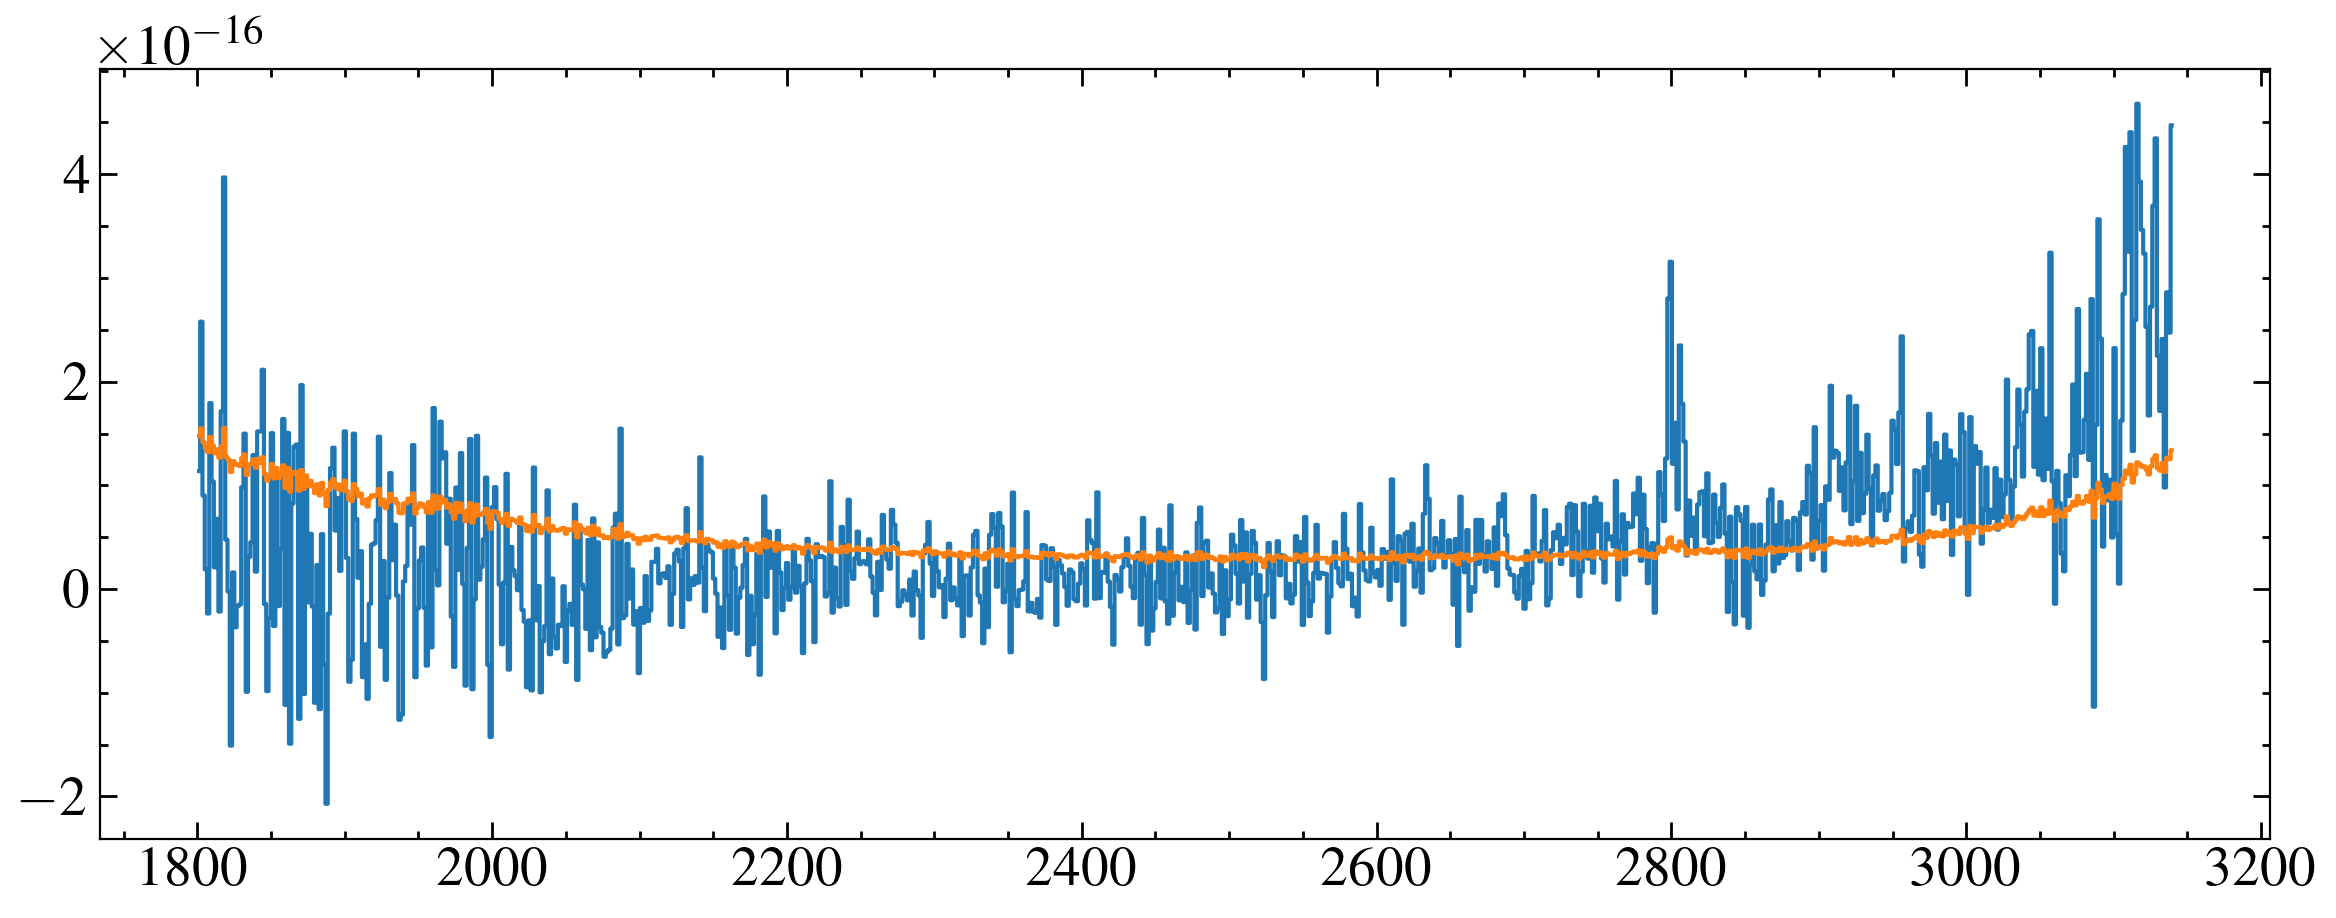

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
528.66766
0.75189805


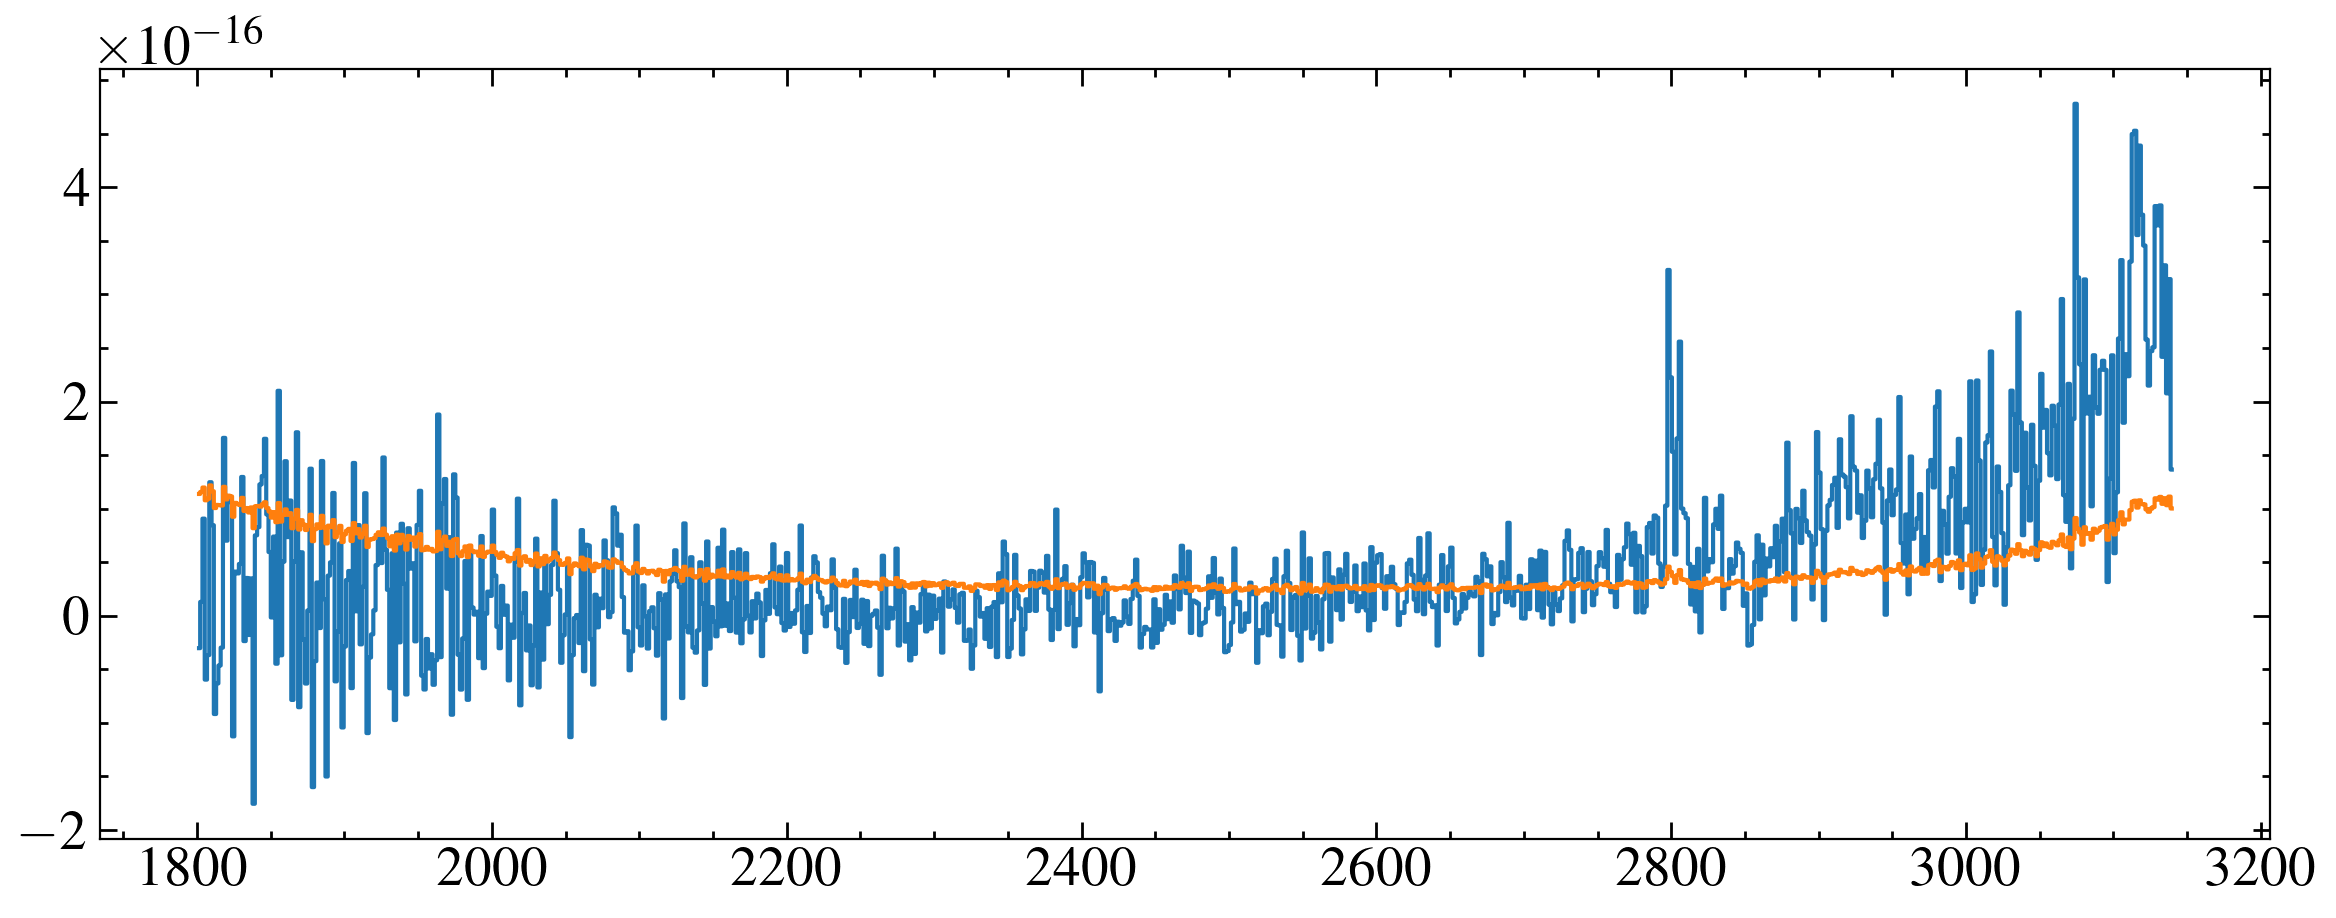

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
528.61176
0.914252


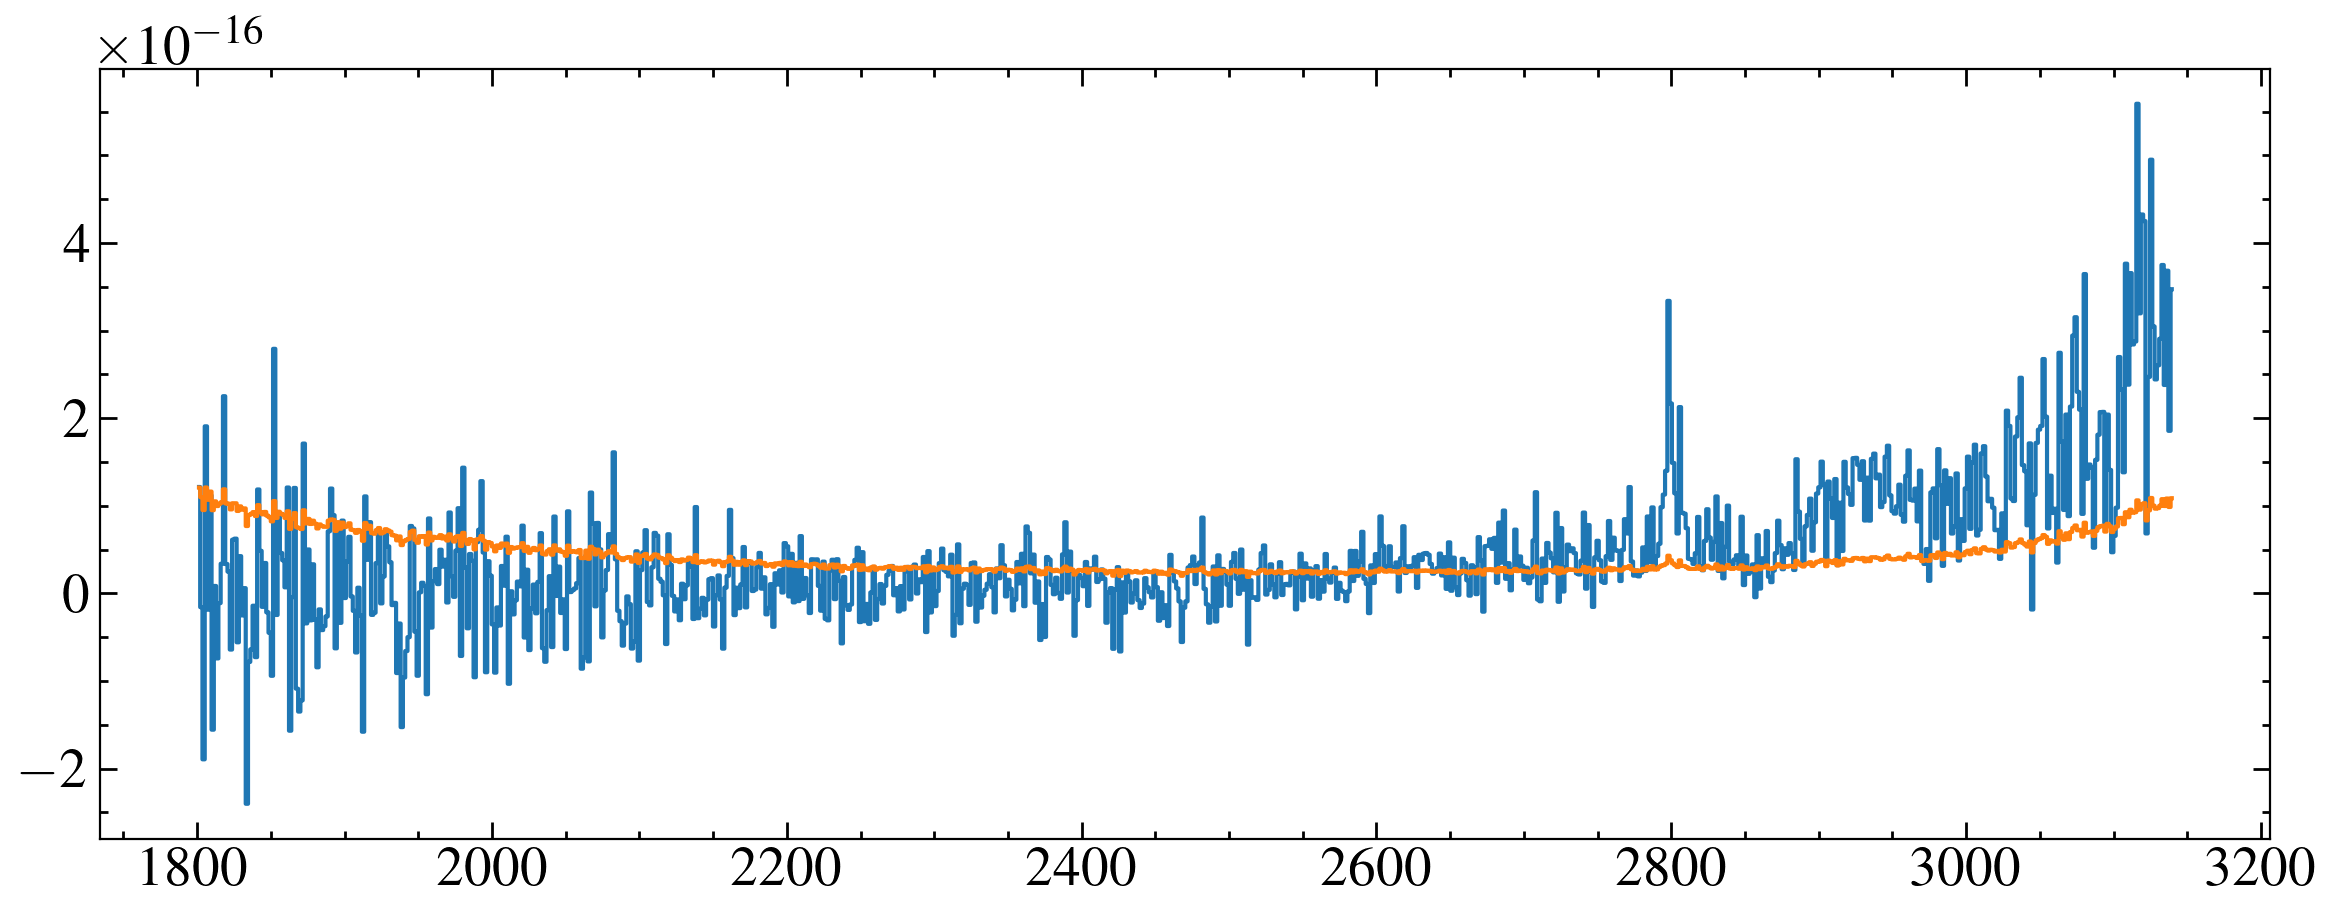

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits
528.526
0.89824116


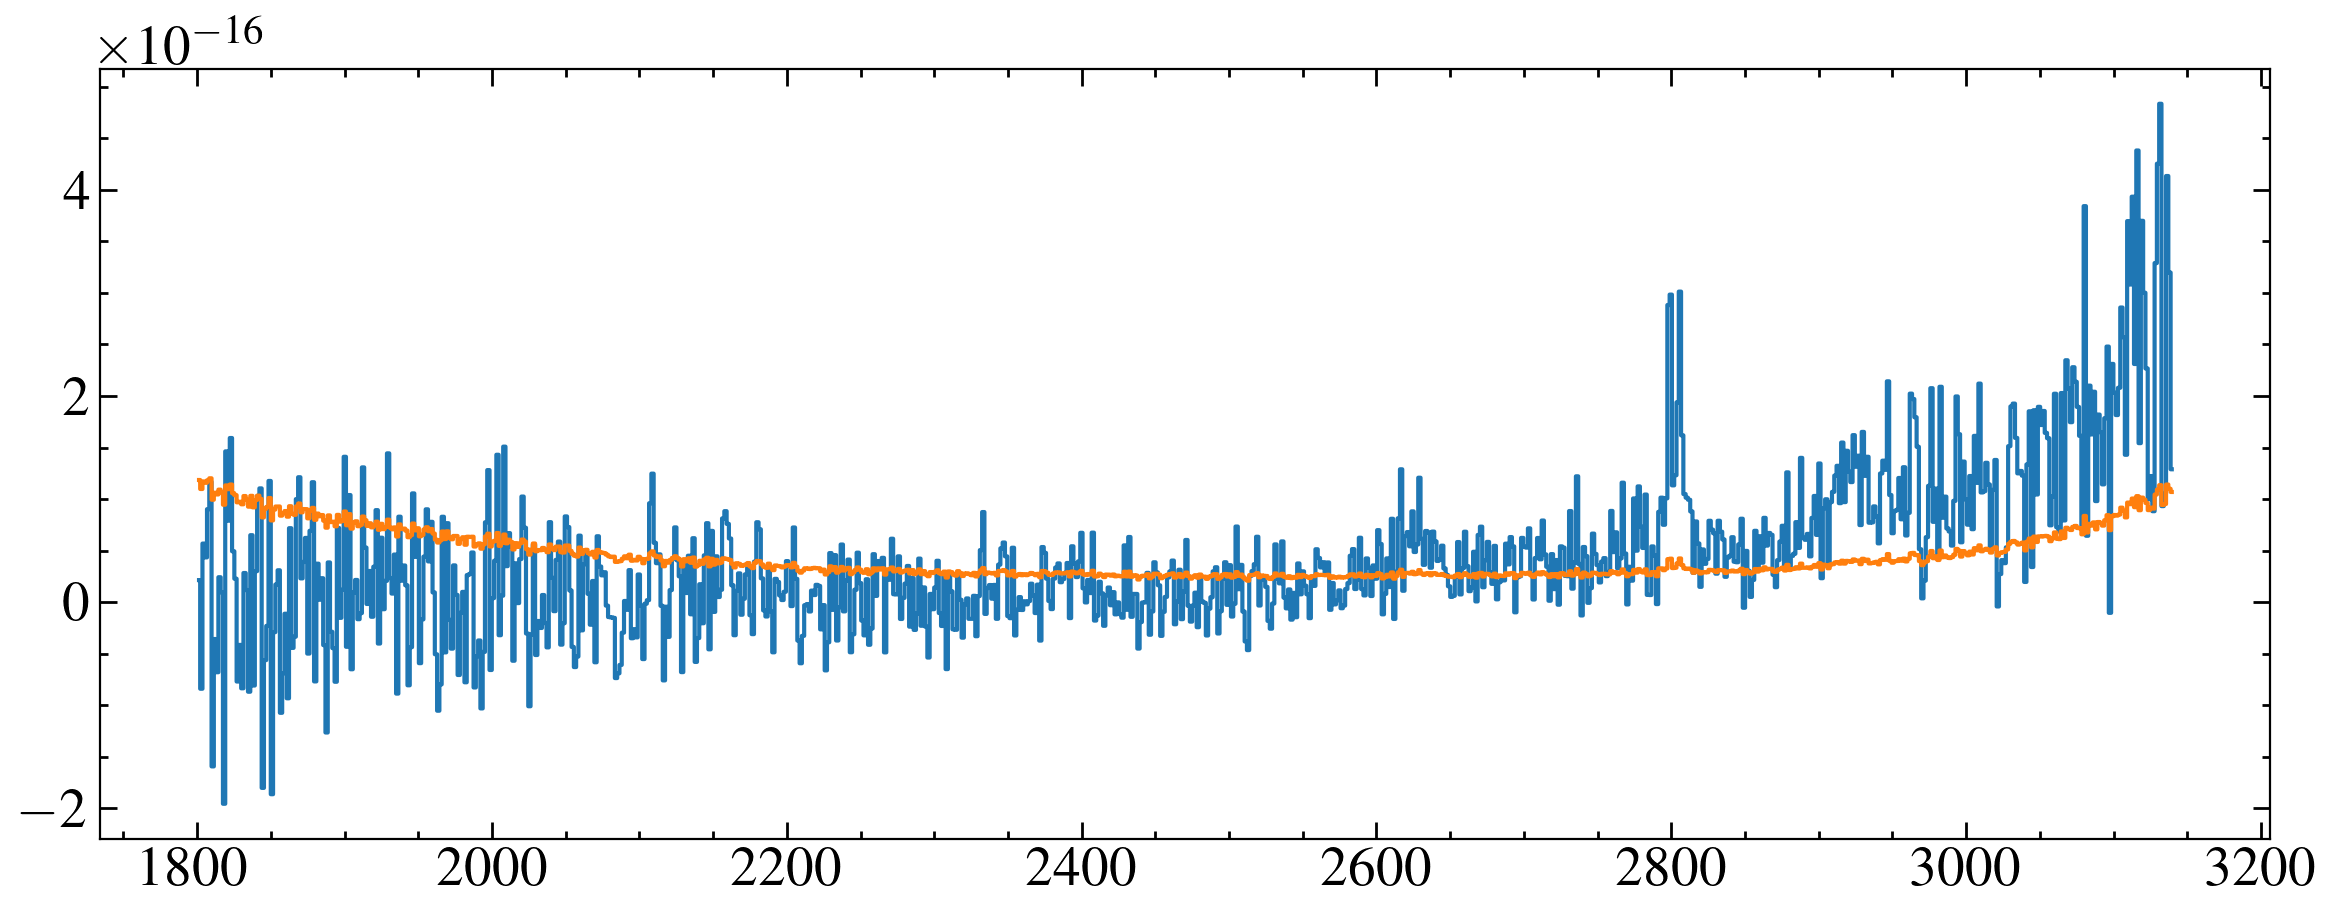

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits
530.57764
0.74627763


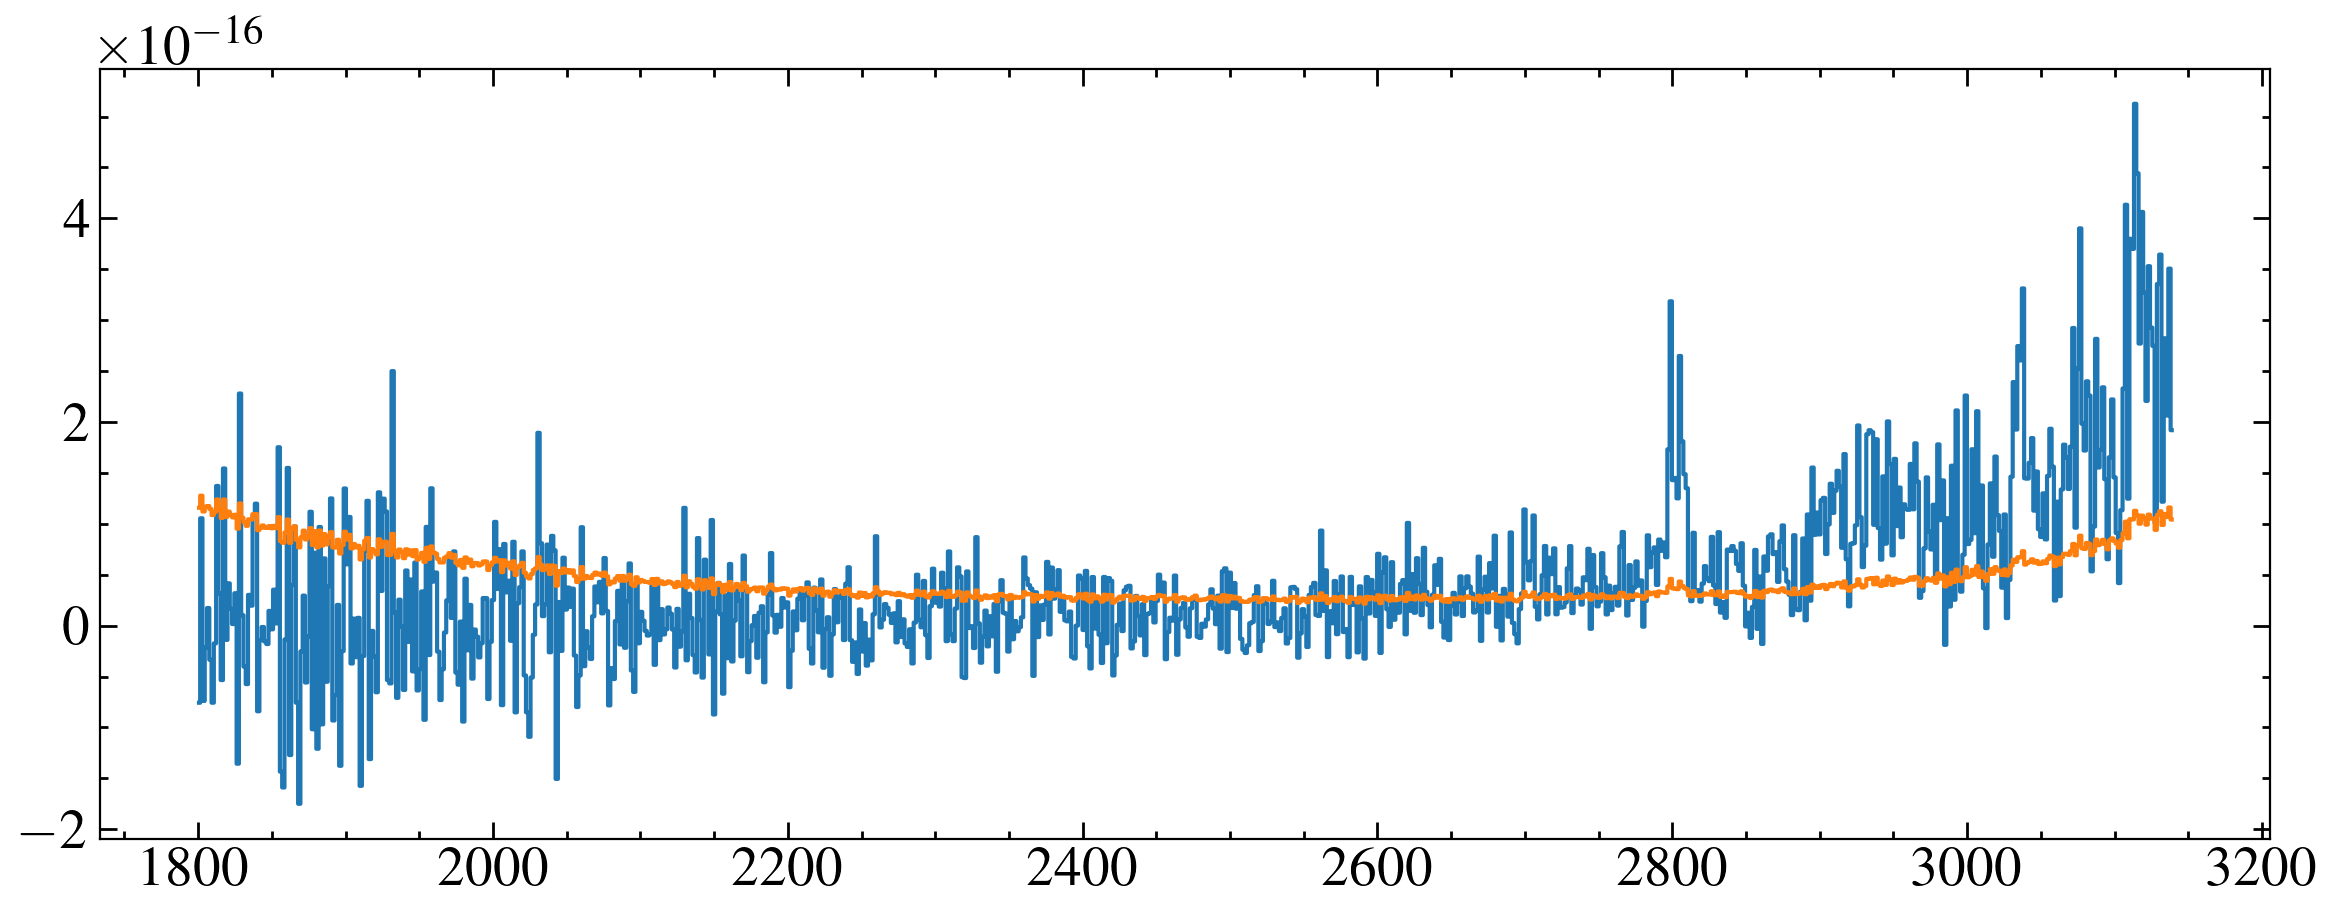

In [4]:
for x in x1ds:
    print(x)
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = (w > 1800) & (w < 3140)
    print(data['A2CENTER'])
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    print(np.median(f/e))
    plt.show()

In [5]:
# fits.getheader(x,0)

In [6]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

In [7]:
fall = []
eall = []


for x in x1ds:
    print(x)
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    fall.append(f)
    eall.append(e)
wn = w
fn, en = spectra_adder(np.array(fall), np.array(eall))


/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits


/tmp/ipykernel_291087/2395719525.py:6: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


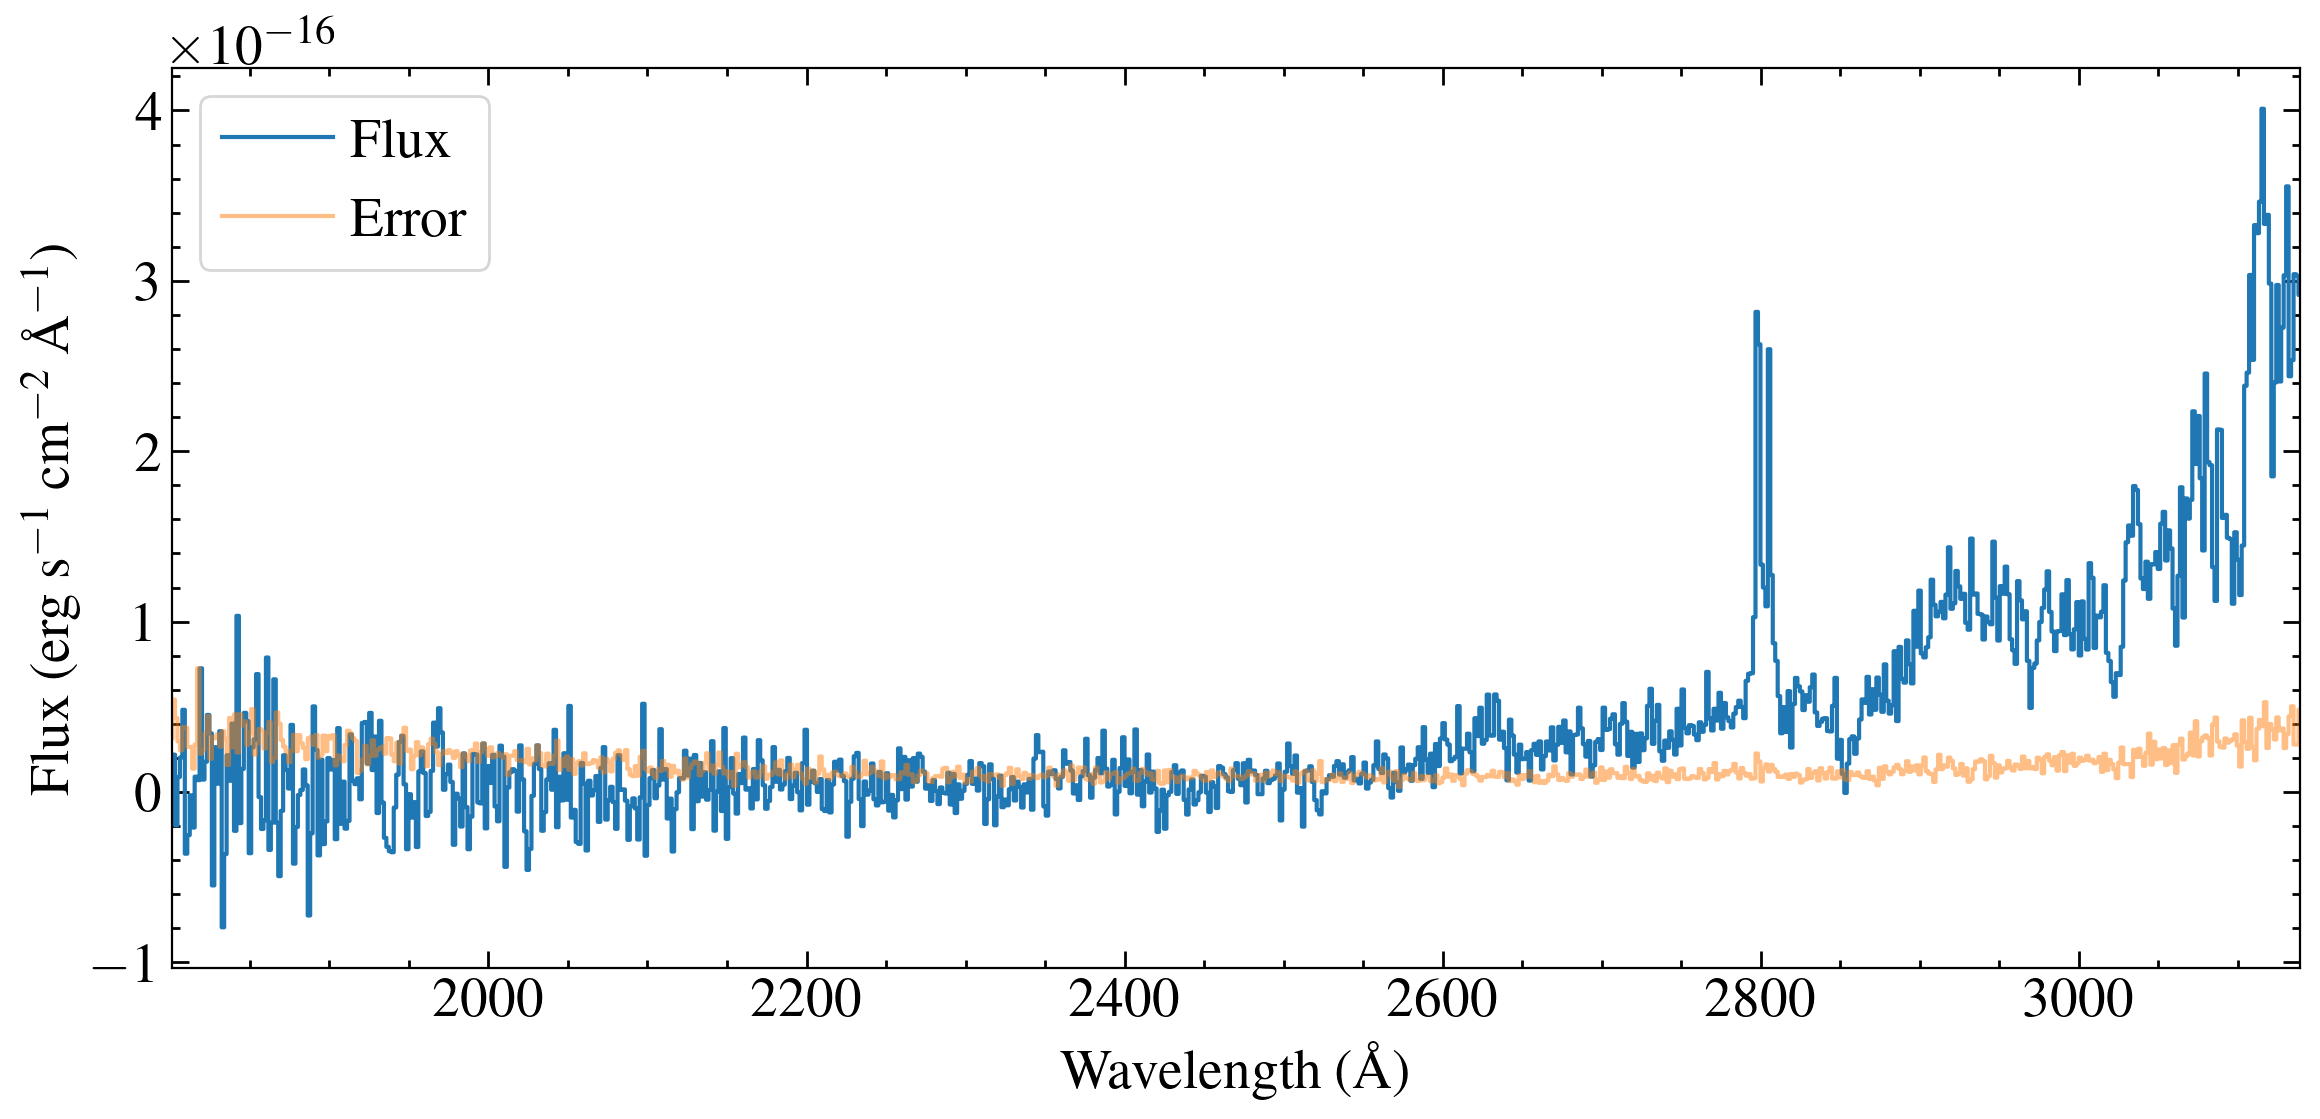

In [8]:
plt.figure(figsize= (12, 6))
mask = (wn > 1800) & (wn < 3140)
plt.step(wn[mask], fn[mask], where='mid', label='Flux')
plt.step(wn[mask], en[mask], where='mid', alpha=0.5, label='Error')

plt.legend(frameon=True)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlim(1801, 3139)
plt.tight_layout()
plt.savefig('plots/ngts-10_g230l_coadd.png', facecolor='w')
plt.savefig('plots/ngts-10_g230l_coadd.pdf')

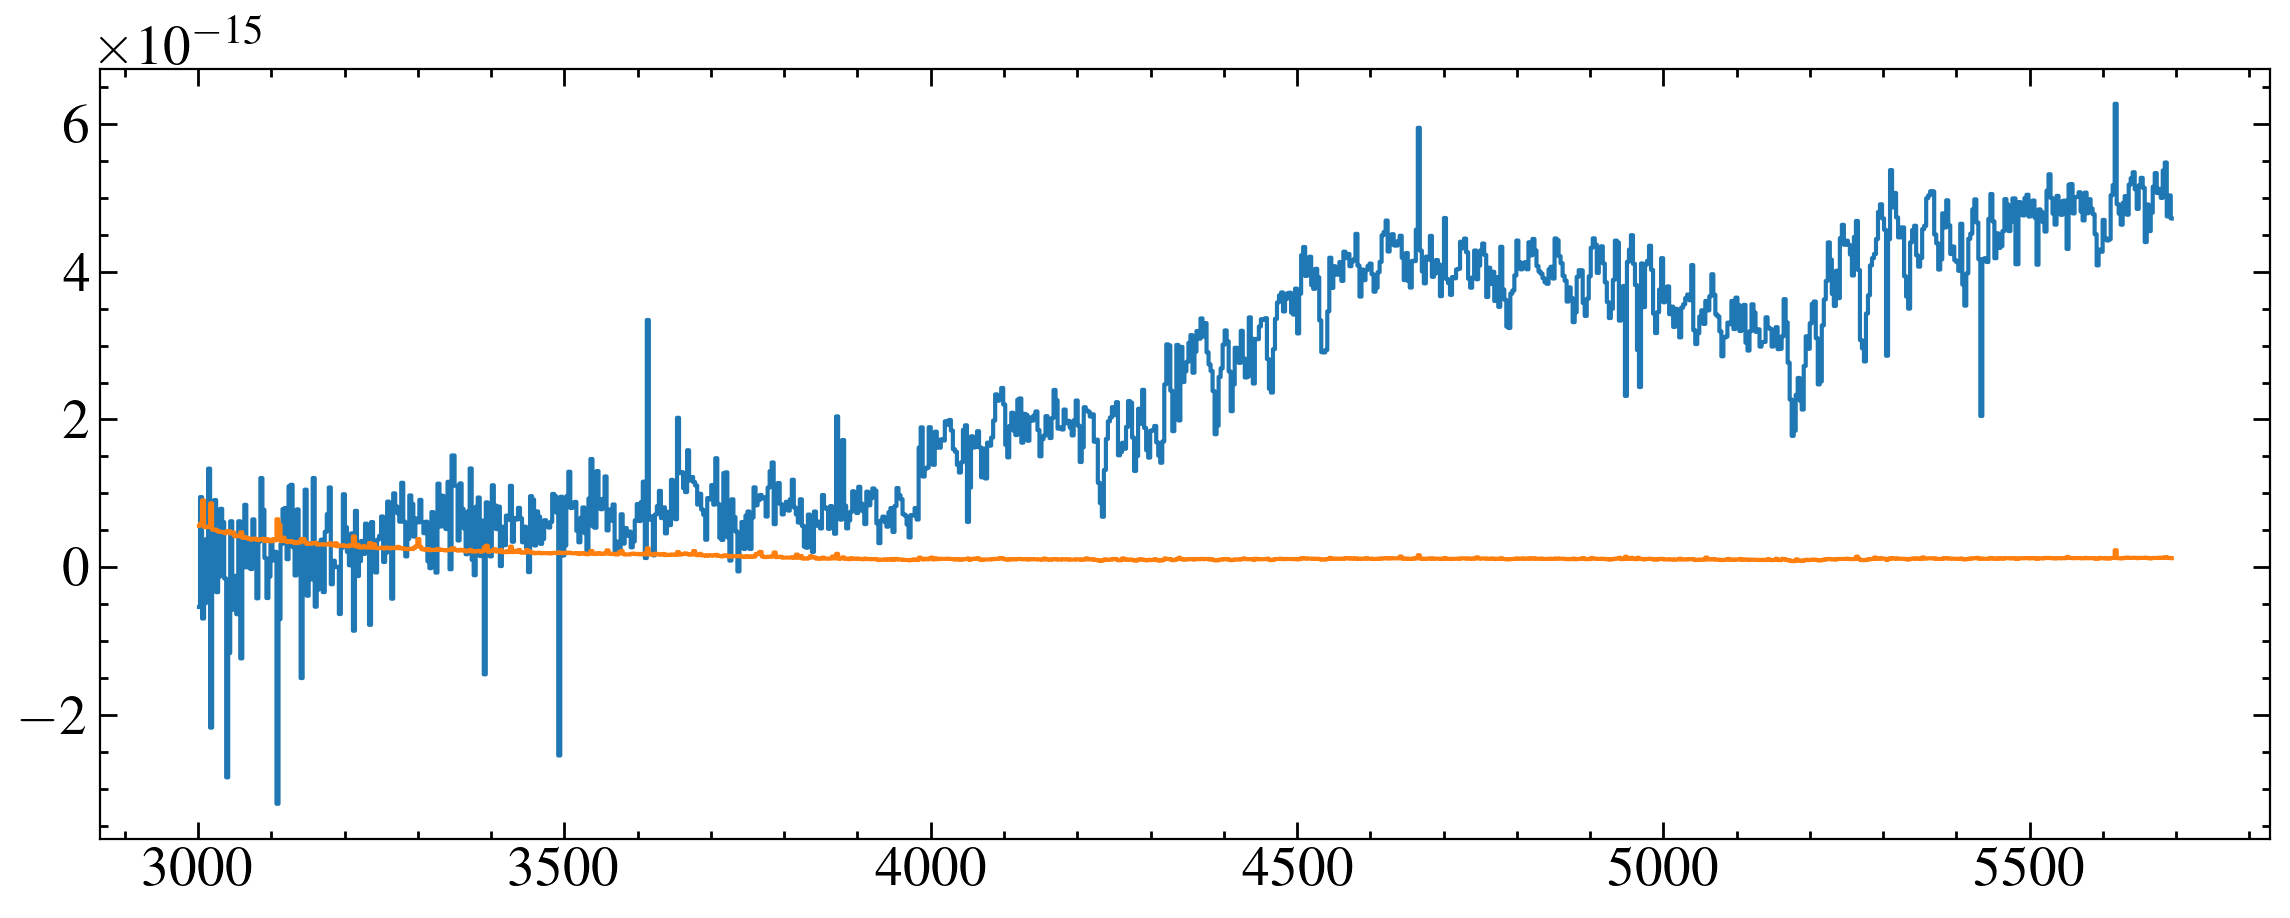

In [9]:
odata = fits.getdata('{}'.format(glob.glob('{}*sx1.fits'.format(path))[0]))[0]
wo, fo, eo = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
mask = (wo > 3000) & (wo <3349) | (wo > 3350) & (wo < 5324) | (wo > 5325) & (wo < 5480) | (wo > 5482) & (wo < 5695)
wo, fo, eo = wo[mask], fo[mask], eo[mask] 
plt.step(wo, fo, where='mid')
plt.step(wo, eo, where='mid')

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits


/tmp/ipykernel_291087/2395719525.py:6: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)


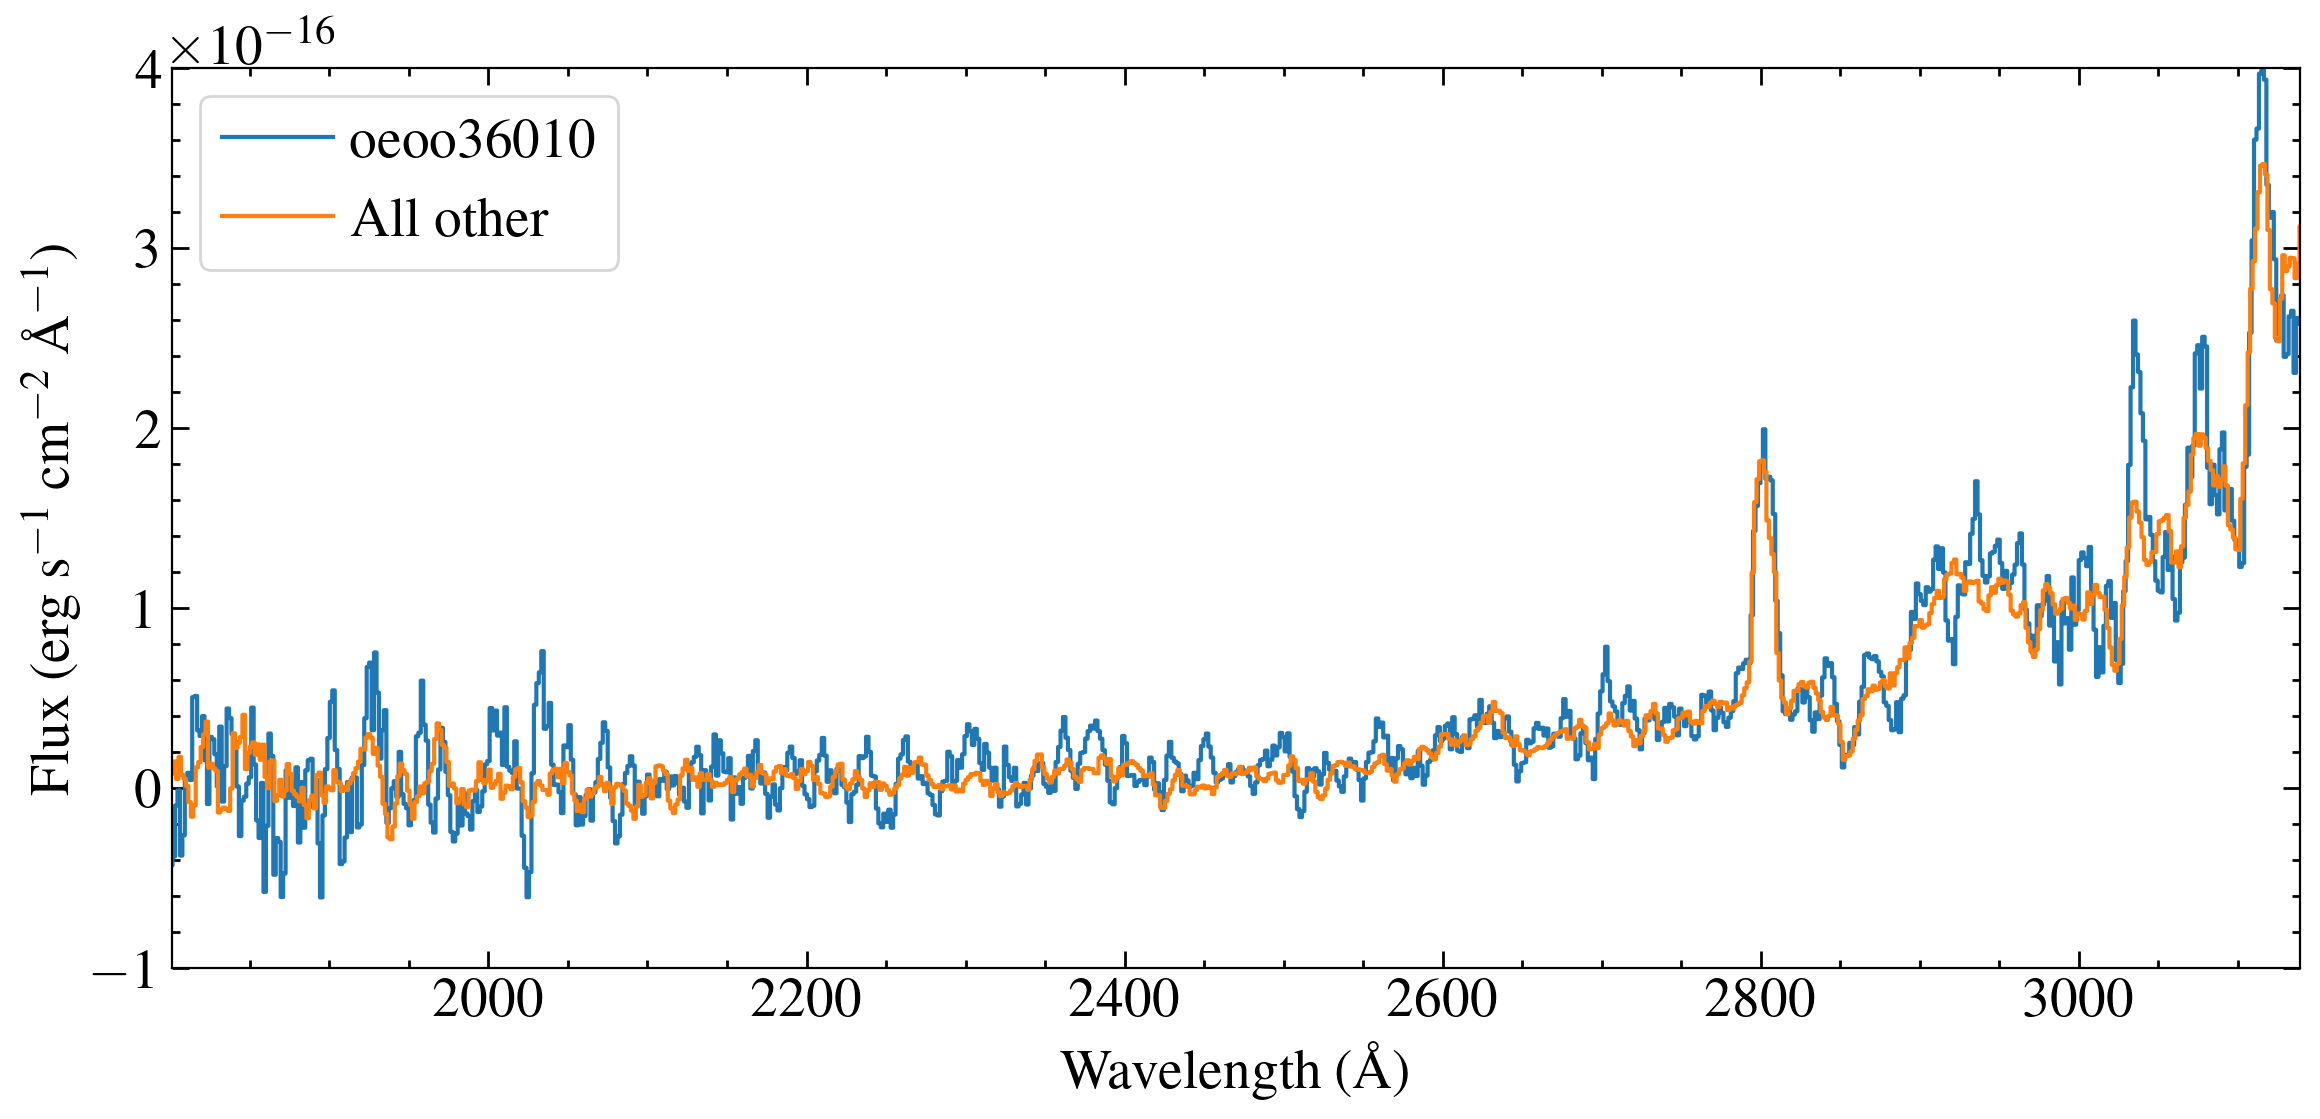

In [10]:
plt.figure(figsize= (12, 6))

data = fits.getdata(x1ds[-1], 1)[0]
root = fits.getheader(x1ds[-1])['ROOTNAME']
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# plt.step(w, f)
fi = convolve(f,Box1DKernel(5))
plt.step(w, fi, where='mid', label=root)

for x in x1ds[:-1]:
    print(x)
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    fall.append(f)
    eall.append(e)

f, e = spectra_adder(np.array(fall), np.array(eall))
fi = convolve(f,Box1DKernel(5))
plt.step(w, fi, where='mid', label = 'All other')
plt.legend(frameon=True)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.ylim(-1e-16, 4e-16)
plt.xlim(1801, 3139)
plt.tight_layout()
plt.savefig('plots/ngts-10_oeoo36010_comp.png', facecolor='w')
plt.savefig('plots/ngts-10_oeoo36010_comp.pdf')

(1e-17, 1.154757691624734e-14)

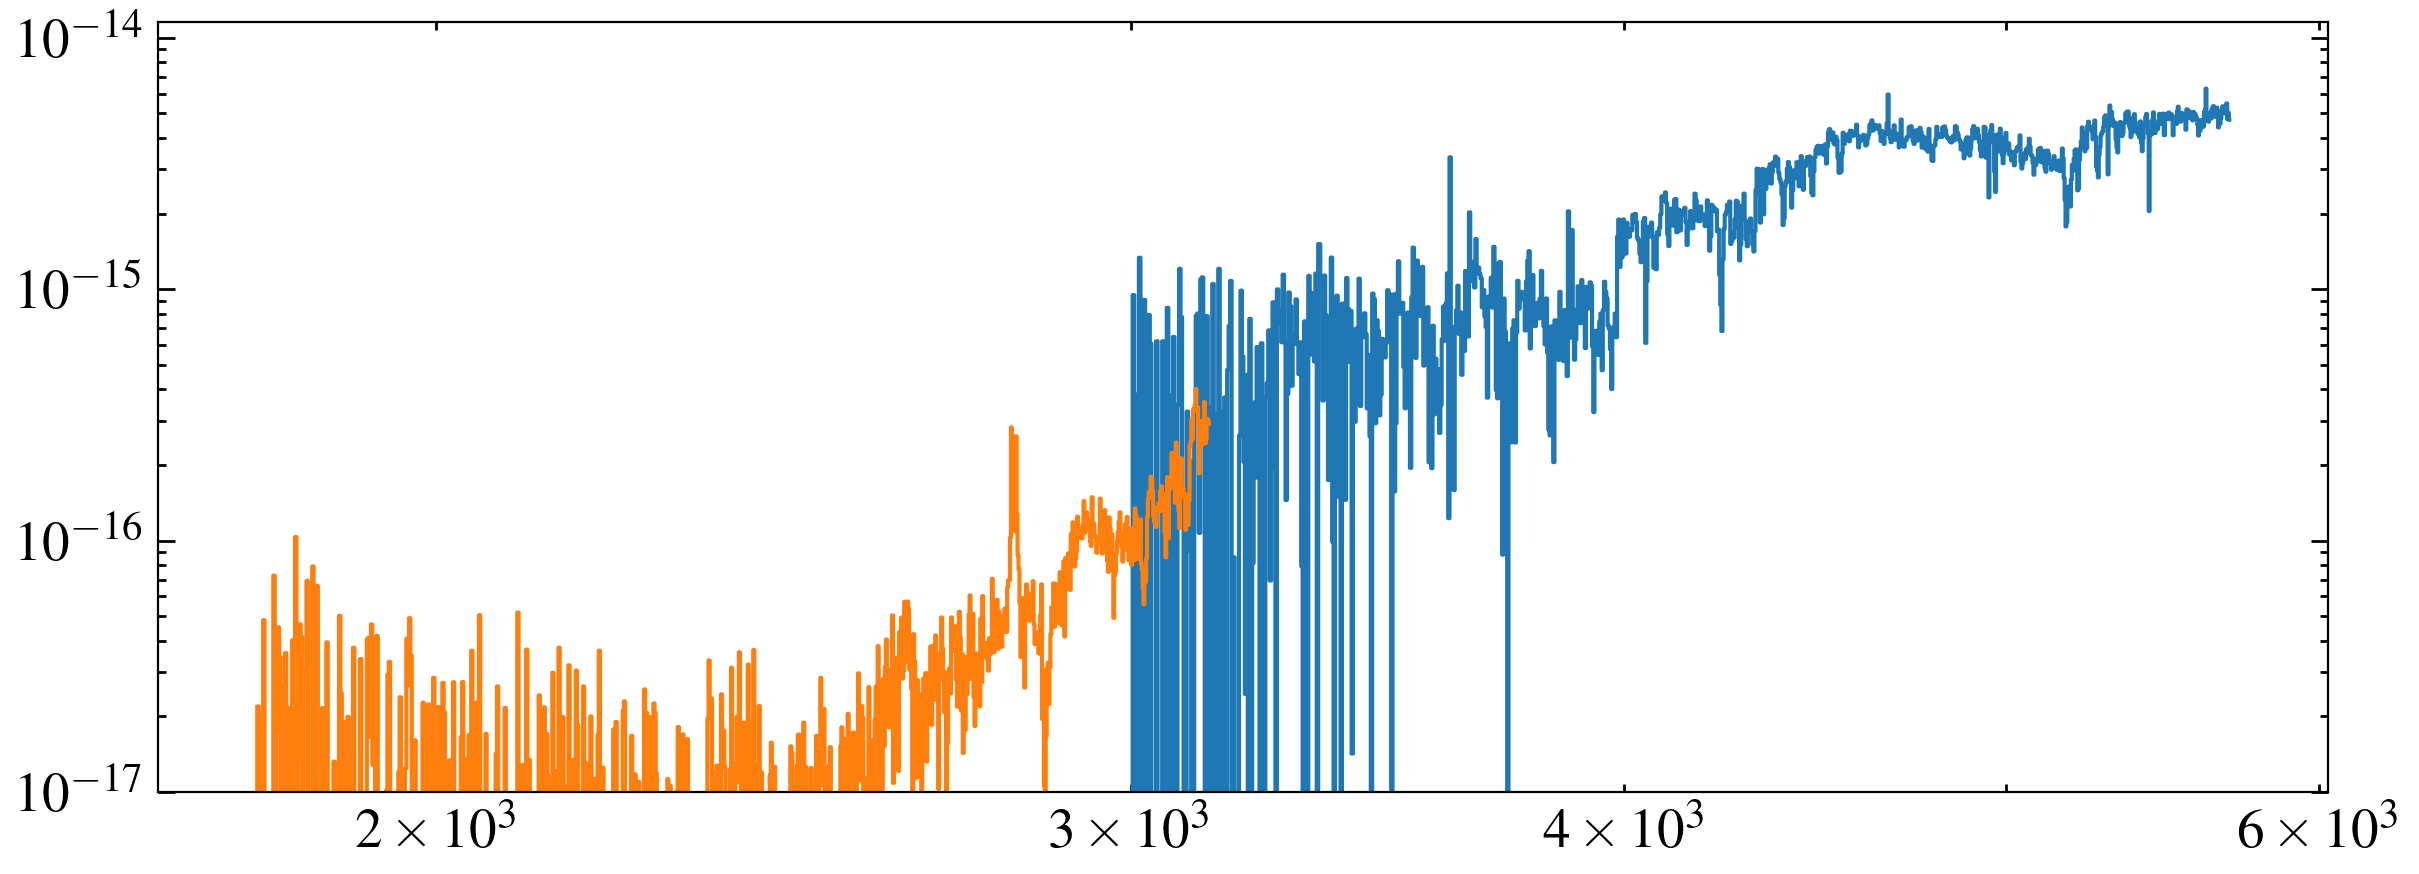

In [11]:
plt.step(wo, fo, where='mid')
mask = (wn > 1800) & (wn < 3140)
plt.step(wn[mask], fn[mask], where='mid', label='Flux')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-17)

Can we detect the planet? doubt it but fun to try.

In [12]:
# fitter = fitting.LevMarLSQFitter()

# mjds = []
# dvs = []
# dveus = []
# dvels = []

# mg2 = [2796.352, 2803.53]
# os = [6.08e-01, 3.03e-01]

# for i, x in enumerate(x1ds):
#     print(x)
#     data = fits.getdata(x, 1)[0]
#     hdr = fits.getheader(x)
    
#     mjds.append((hdr['TEXPSTRT']+hdr['TEXPEND'])/2)
    
#     w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    
#     mask = (w > 2780) & (w < 2820)
#     wl, fl, el = w[mask], f[mask], e[mask]



#     plt.step(wn, fn, where='mid')
#     plt.step(wn, en, where='mid')
#     # plt.plot(wp, fp)
#     # plt.yscale('log')
#     [plt.axvline(line, ls='--', c='C1') for line in mg2]

#     lines = np.copy(mg2)

#     mod = models.Const1D(0)#, fixed=dict(amplitude=True))
#     for line in lines:
#         line_guess = (+39*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#         # mod = mod+  models.Gaussian1D(amplitude=np.max(fn)/2, mean = line_guess, stddev=1)
#         mod = mod + models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1)#, bounds=dict(amplitude_L=[0, 1]))
#         # plt.axvline(line, ls='--', c='C2', alpha =0.5)
#         plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

#     def tiedfunc0(mod):
#         mean = mod.mean_1.value+np.diff(lines)
#         return mean

#     def tiedfunc1(mod):
#         x_0 = mod.x_0_1.value+np.diff(lines)
#         # fwhm_G = mod.fwhm_G_1.value
#         return x_0

#     def tiedfwhmg(mod):
#         fwhm_G = mod.fwhm_G_1.value
#         return fwhm_G

#     def tiedfwhml(mod):
#         fwhm_L = mod.fwhm_L_1.value
#         return fwhm_L

#     def tiedamp(mod):
#         amplitude = mod.amplitude_L_1.value/(os[0]/os[1])
#         return amplitude

#     # mod.mean_2.tied=tiedfunc0
#     mod.x_0_2.tied=tiedfunc1
#     mod.fwhm_G_2.tied=tiedfwhmg
#     mod.fwhm_L_2.tied=tiedfwhml
#     mod.amplitude_L_2.tied = tiedamp

#     gg_fit = fitter(mod, wl, fl, maxiter=100000)

#     # print(gg_fit)


#     if type(fitter.fit_info['param_cov']) == np.ndarray:
#     #     print('hooray!')
#         fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#         print(fit_e)
#     mean, mean_e = gg_fit[1].x_0, fit_e[1]    
#     dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(mg2[0]*u.AA))
#     eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(mg2[0]*u.AA))
#     edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(mg2[0]*u.AA))
#     dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
#         # print(dv, dve)
#     print(dv, dv-edo, eup-dv)
      
#     dvs.append(dv.value)
#     dveus.append((eup-dv).value)
#     dvels.append((dv-edo).value)

#     plt.plot(wl, gg_fit(wl))
    
#     plt.show()

# mjds, dvs, dveus, dvels = np.array(mjds), np.array(dvs), np.array(dveus), np.array(dvels)

In [13]:
# #https://academic.oup.com/mnras/article/493/1/126/5735996?login=true
# p = 0.7668944 #d
# g = 39.0931 
# ge = 0.0057
# k = 0.5949
# keu = 0.0077
# ked = 0.0063




# tfold = mjds/p % 1
# plt.errorbar(tfold, dvs, yerr= [dveus, dvels], marker='o', ls='none')

# orbit = models.Sine1D(k, 1, phase=0.5, bounds=dict(amplitude=[k-ked, k+keu]), fixed=dict(frequency=True))+models.Const1D(g)#, bounds=dict(amplitude=[g-ge, g+ge]))
# orbit = models.Sine1D(k, 1, fixed=dict(frequency=True))+models.Const1D(g)#, bounds=dict(amplitude=[g-ge, g+ge]))
# orbfit = fitter(orbit, tfold, dvs, maxiter=10000)

# tmod = np.linspace(0, 1, 1000)
# plt.plot(tmod, orbfit(tmod))
# orbfit

No.

In [14]:
1000/3.8713694898542497

258.3065250218853

In [32]:
import prepare_phoenix_svo as pp
import importlib
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.696
# teff = 5715
teff = 4601 #nb prepare phx bugs if there is an available model, fix asap
teff_e = 150
# radius = 1.79
radius = 0.697
# distance = 324.69865035832692
distance = 1000/3.8714
print(distance)
save_path = 'models/'
star = 'NGTS-10'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
# print(np.log10(g.value))
g = 4.5
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

258.3044893320246


In [17]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

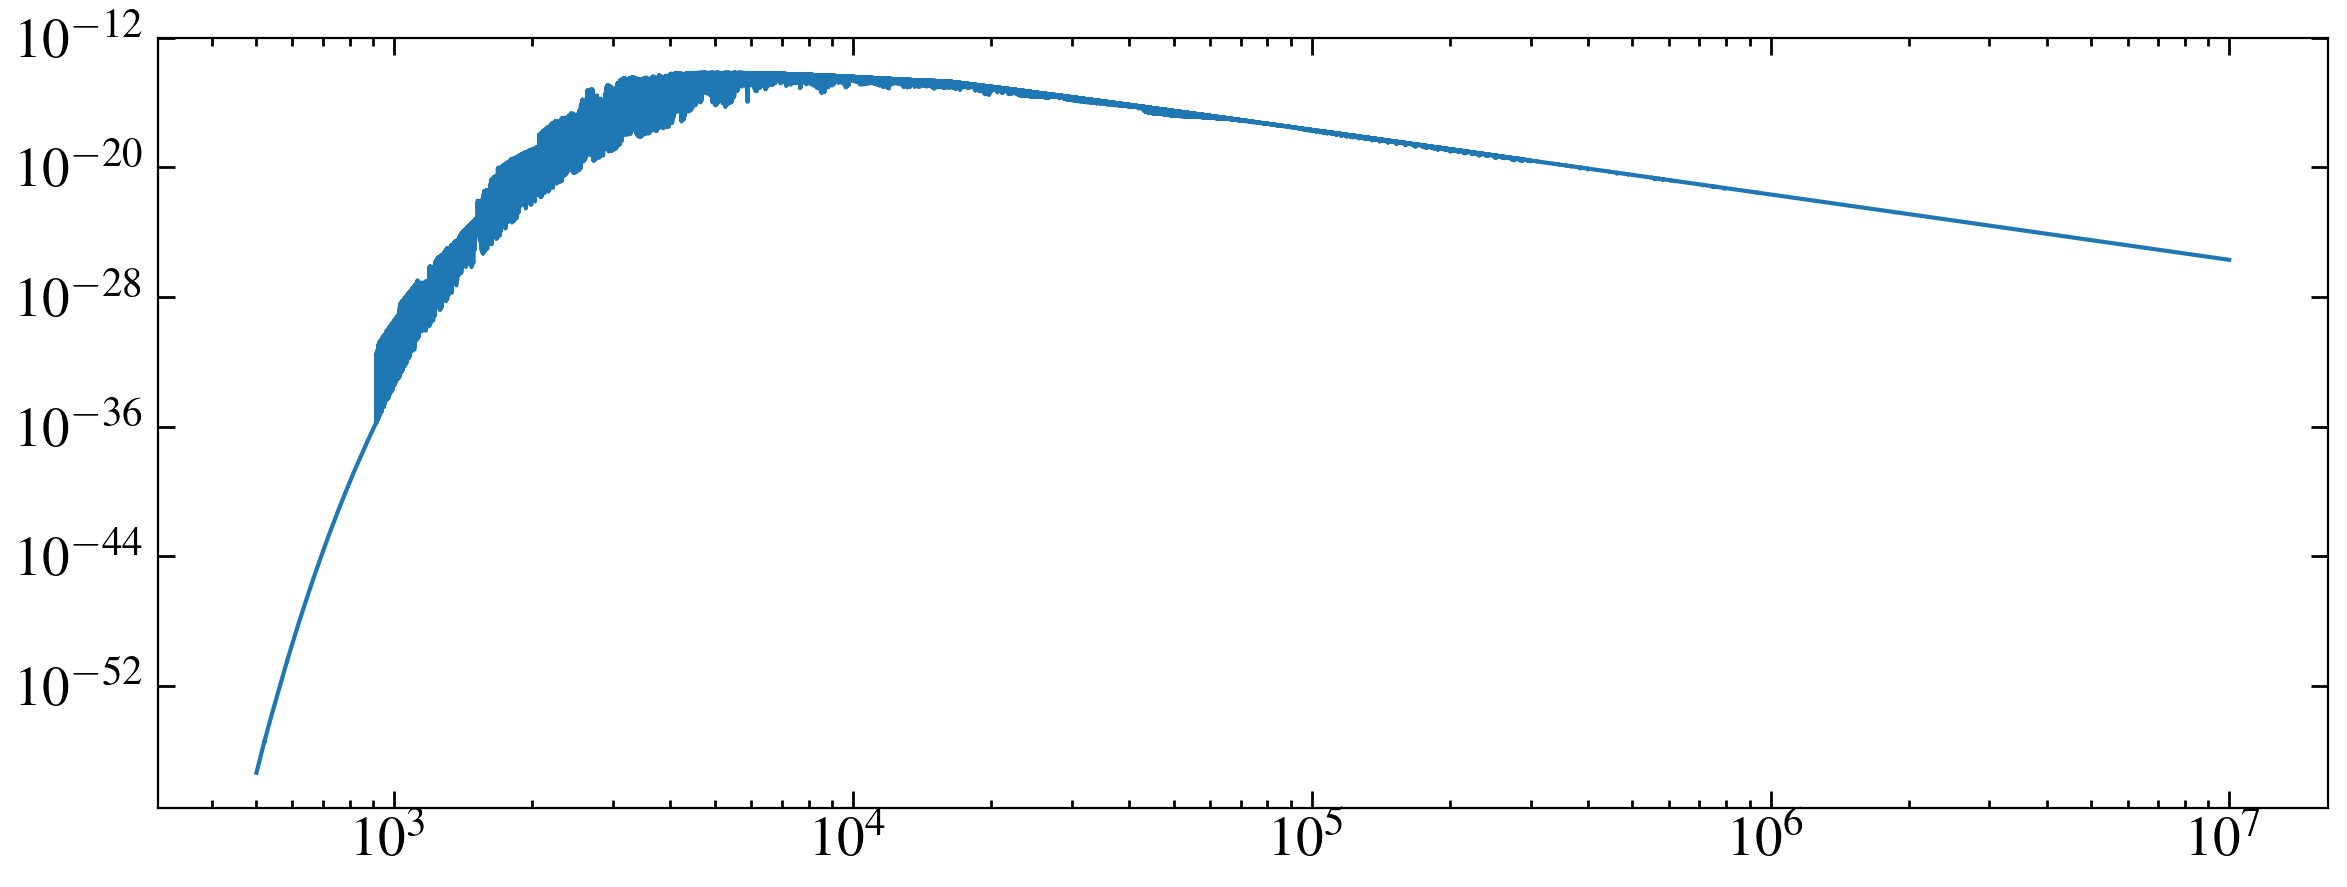

In [18]:
plt.plot(pw, pf*normfac)
plt.yscale('log')
plt.xscale('log')

In [19]:
nw, nf, ne = wn, fn, en #oops
ow, of, oe = wo, fo, eo 

In [20]:
from dust_extinction.parameter_averages import F99
print(0.0366/3.1)

0.011806451612903225


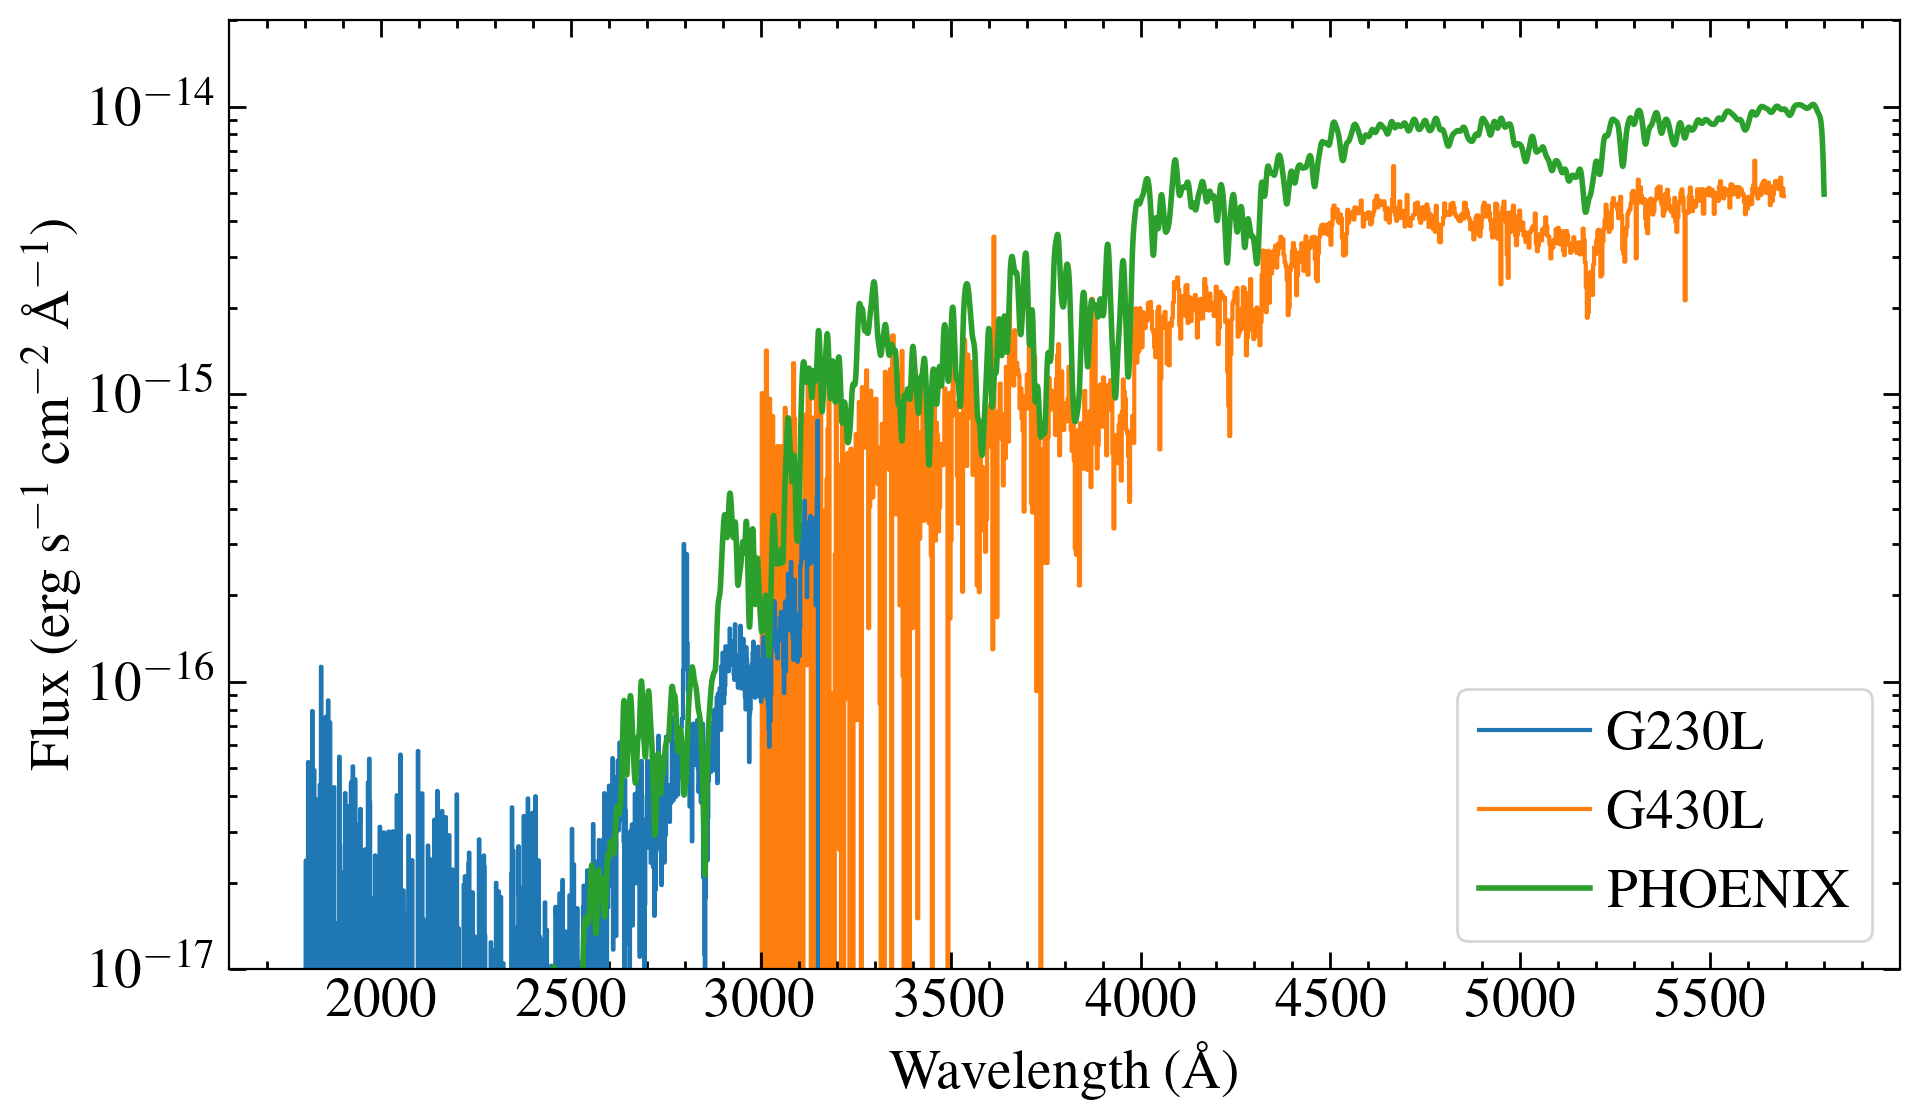

In [33]:
ext = F99(Rv=3.1)


pmask = (pw > 1900) & (pw < 5800)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 1000)
plt.figure(figsize=(10, 6))
# plt.step(nw[nw > 1800], nf[nw > 1800], where='mid', label= 'G230L')
redn = ext.extinguish(nw[nw > 1800]*u.AA, Ebv = 0.012)
plt.step(nw[nw > 1800], nf[nw > 1800]/redn, where='mid', label= 'G230L')


# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow, of, where='mid', label='G430L', zorder=-1)
redo = ext.extinguish(ow*u.AA, Ebv = 0.012)
plt.step(ow, of/redo, where='mid', label='G430L', zorder=-1)

# plt.xlim(3200, 3400)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

# plt.title('WASP-63')
# plt.xlim(1980, 5650)
plt.ylim(1e-17, 2e-14)
plt.tight_layout()


PHX overpredicts even with reddening 

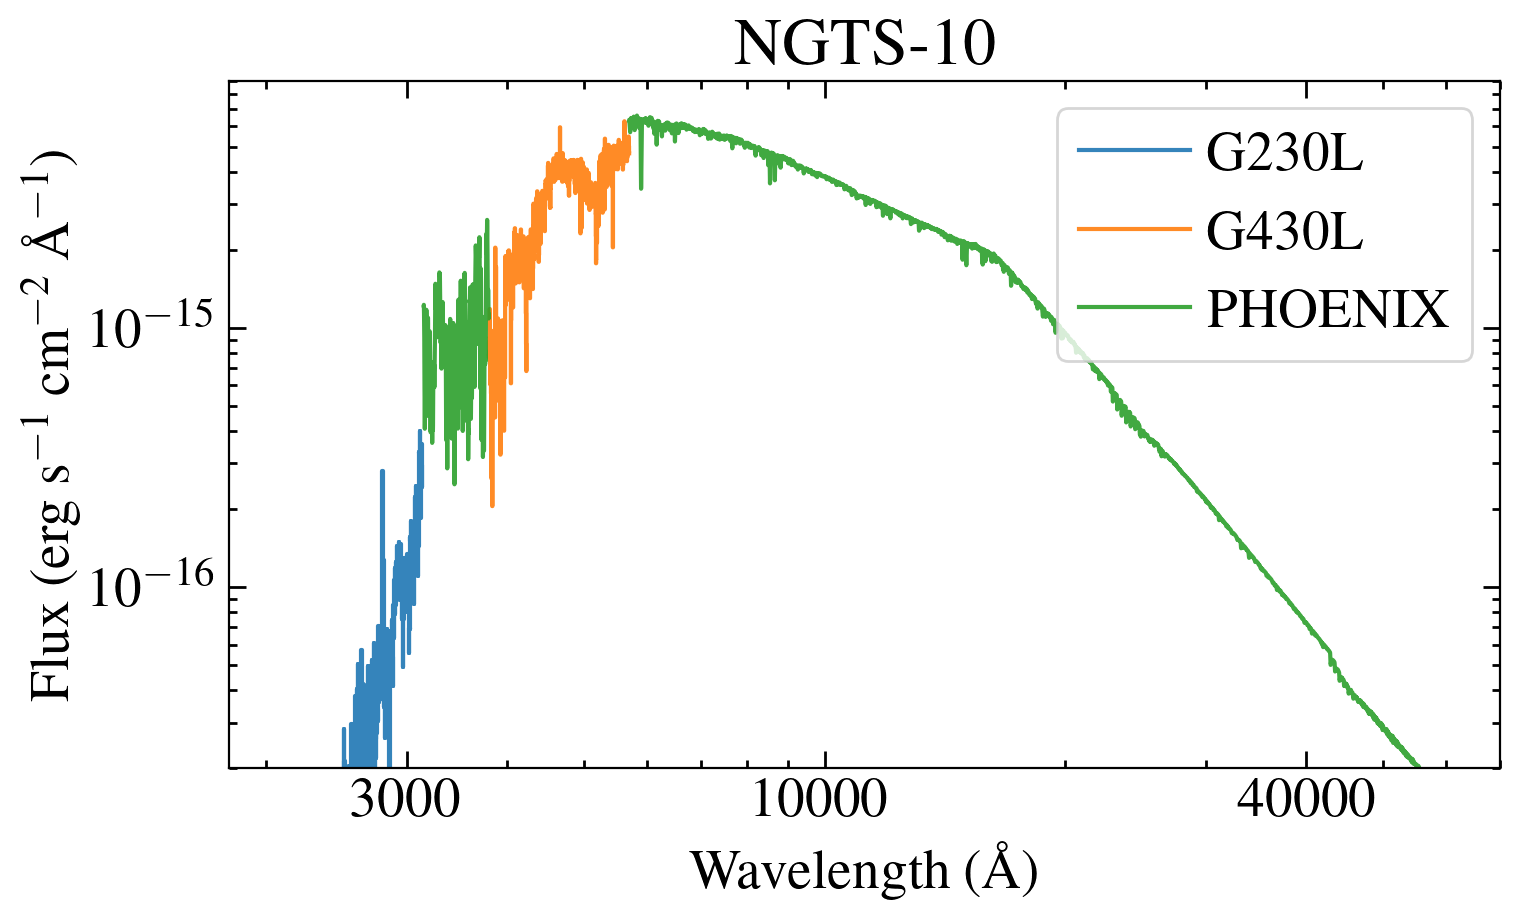

In [29]:
pwi, pfi = smear(pw, pf, 2000)
pmask = (pwi > 1800) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(8,5))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
nmask = (nw > 2500) & (nf > 0) & (nw < 3140) 
plt.step(nw[nmask], nf[nmask], where='mid', label= 'G230L', alpha=0.9)
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow[(ow > 3800)], of[(ow > 3800)], where='mid', label='G430L', zorder=-1, alpha=0.9)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
pmask2 = (pwi > nw[-1]) & (pwi < 3800) 
plt.plot(pwi[pmask2], pfi[pmask2], label= 'PHOENIX', alpha=0.9)
pmask3 = pwi > ow[-1] 
plt.plot(pwi[pmask3], pfi[pmask3], c='C2', alpha=0.9)
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
plt.legend(frameon=True, loc=1)
plt.title('NGTS-10')
plt.xlim(1800, 70000)
plt.ylim(2e-17, 9e-15)
plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/NGTS-10_ql.png', facecolor= 'w')

/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


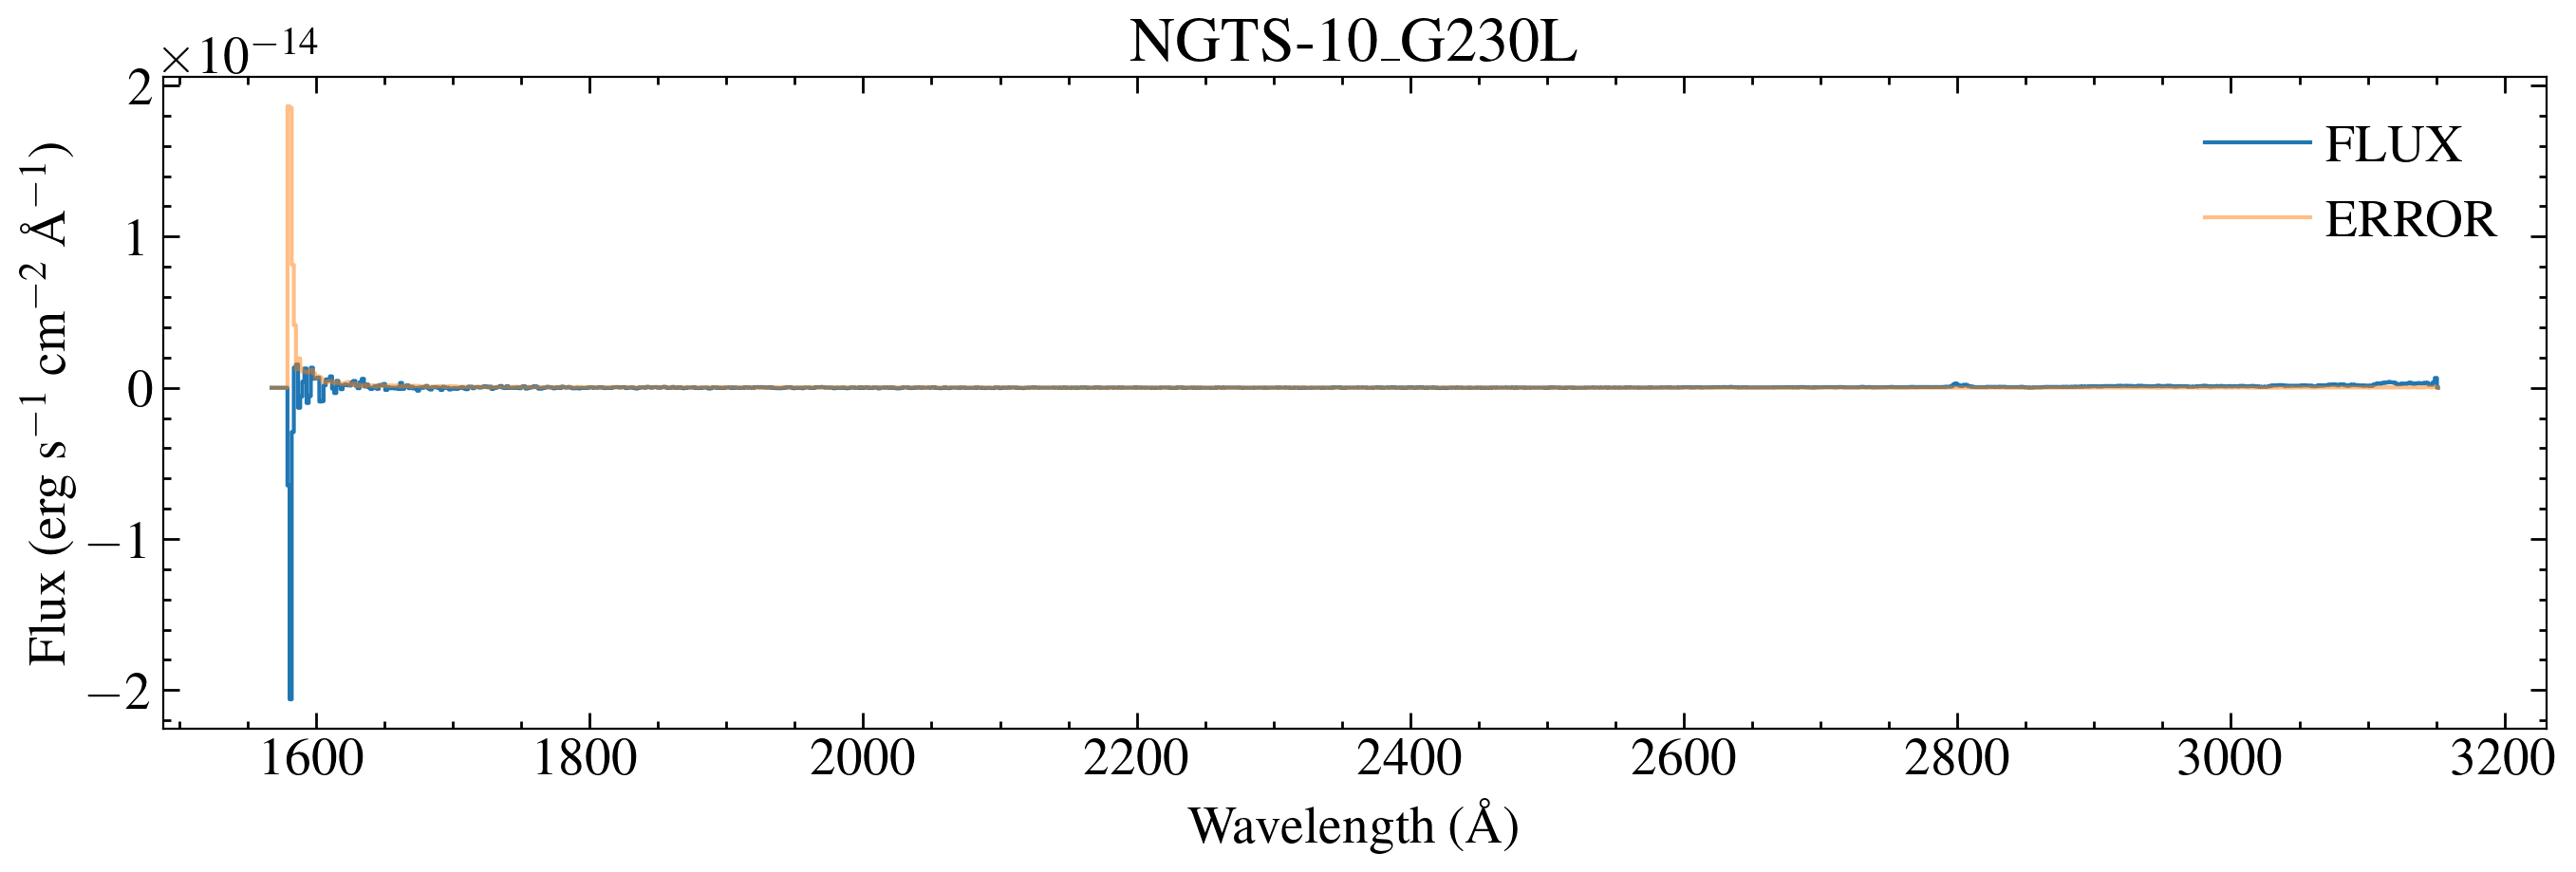

Spectrum saved as hlsp_muscles_hst_stis_ngts-10_g230l_v1_component-spec.fits


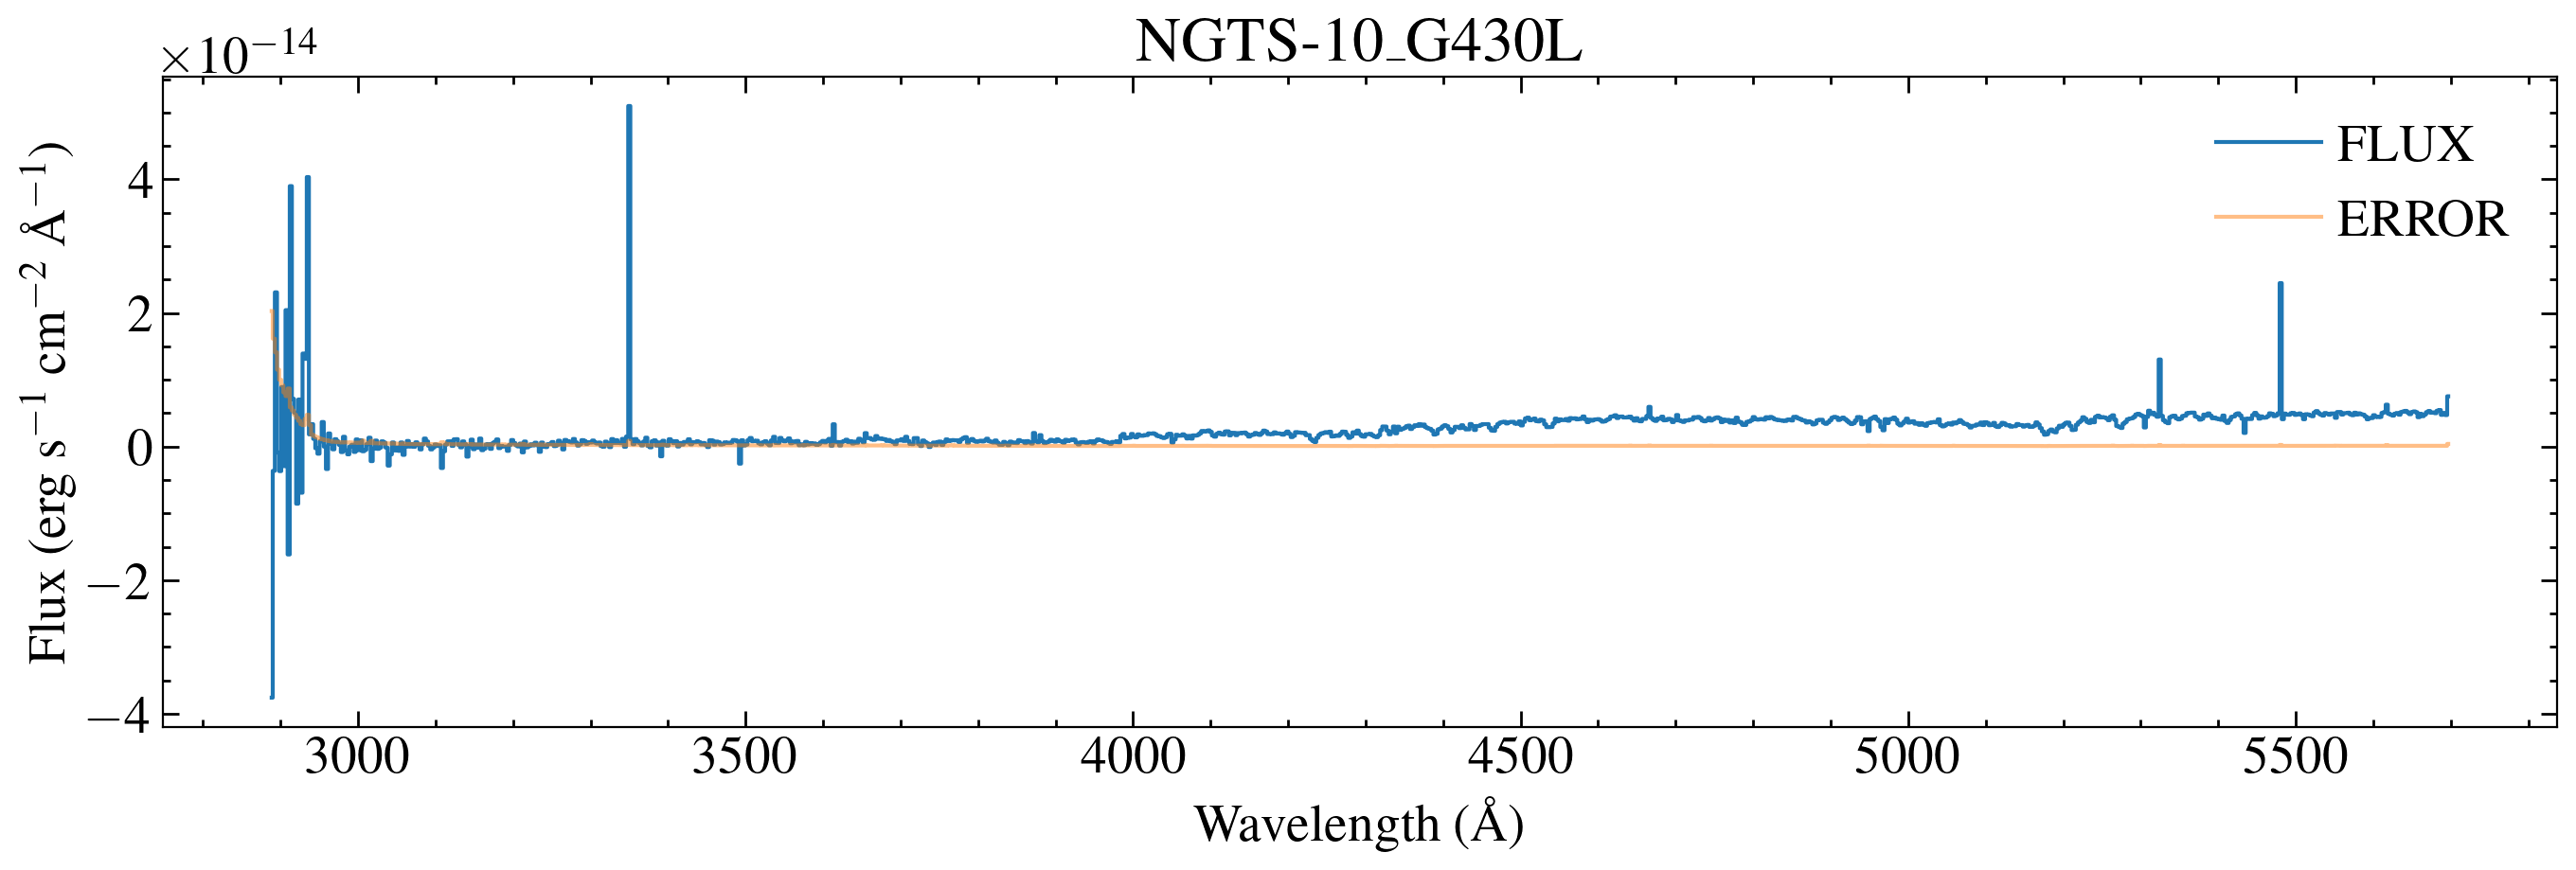

Spectrum saved as hlsp_muscles_hst_stis_ngts-10_g430l_v1_component-spec.fits


In [23]:
import prepare_stis
x1dpath = path
savepath = 'draft_hlsp/ngts-10/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'NGTS-10')

In [24]:
import prepare_model
hdr = fits.getheader('draft_hlsp/ngts-10/hlsp_muscles_hst_stis_ngts-10_g230l_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
#PHX
# prepare_model.make_model_spectrum('models/NGTS_10_phoenix_interpolated.ecsv', 1, sed_data,
                                  # savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


Spectrum saved as hlsp_muscles_model_phx_ngts-10_na_v1_component-spec.fits


1214.0 1217.399999999997
Spectrum saved as hlsp_muscles_model_lya_ngts-10_na_v1_component-spec.fits


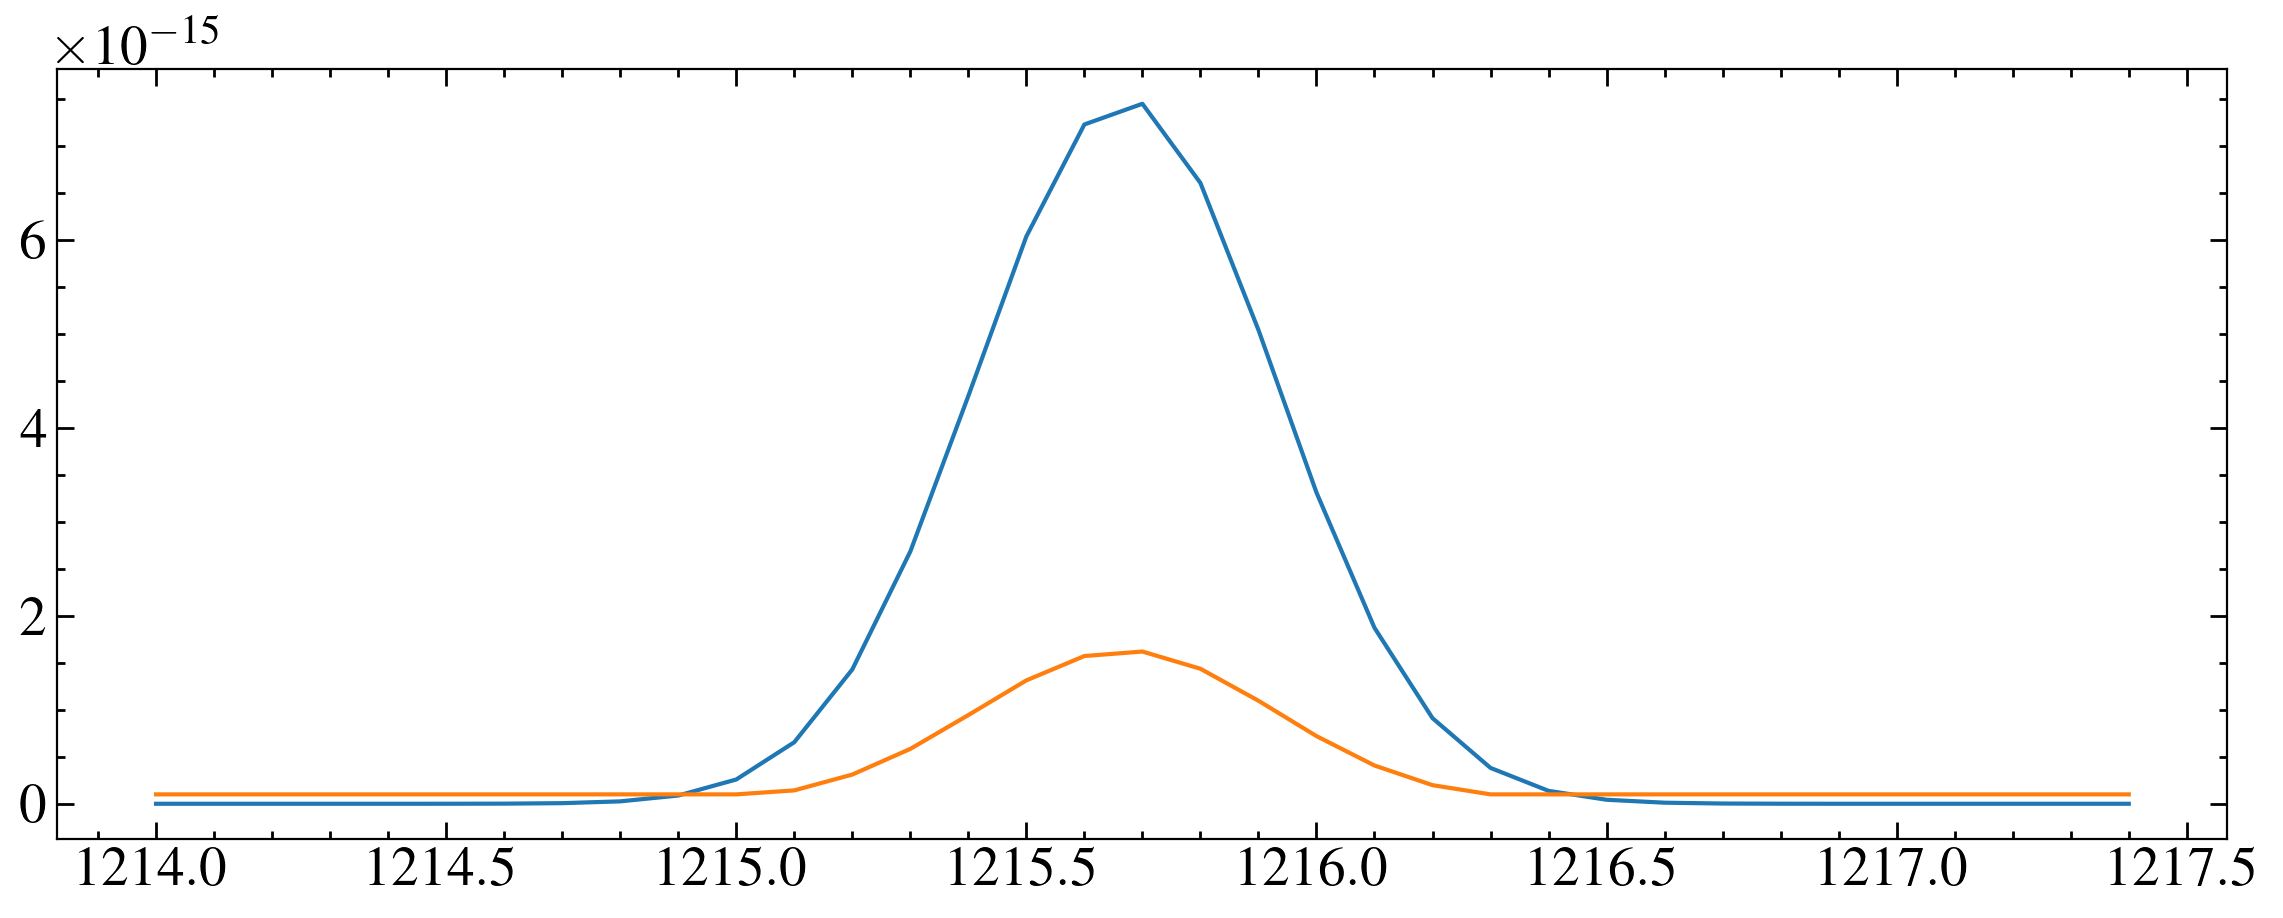

In [25]:
#lya
lyatab = Table.read('/media/david/2tb_ext_hd/hddata/meats/lya/ngts-10/NGTS10_LyA_estimate.txt', format='ascii.basic')
lw, lf, le = lyatab['WAVELENGTH'], lyatab['FLUX'], lyatab['ERROR']
lyatab.write('models/NGTS-10_LyA_estimate.ecsv', format='ascii.ecsv', overwrite=True)
plt.plot(lw, lf)
plt.plot(lw, le)
print(lw[0], lw[-1])

prepare_model.make_model_spectrum('models/NGTS-10_LyA_estimate.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


How to scale 70-Oph B? No regions of overlap...

In [26]:
hlsp = glob.glob('draft_hlsp/ngts-10/*.fits')
hlsp

['draft_hlsp/ngts-10/hlsp_muscles_model_phx_ngts-10_na_v1_component-spec.fits',
 'draft_hlsp/ngts-10/hlsp_muscles_model_lya_ngts-10_na_v1_component-spec.fits',
 'draft_hlsp/ngts-10/hlsp_muscles_hst_stis_ngts-10_g230l_v1_component-spec.fits',
 'draft_hlsp/ngts-10/hlsp_muscles_hst_stis_ngts-10_g430l_v1_component-spec.fits']

In [27]:
hlsp_70_oph = glob.glob('draft_hlsp/70_Oph_B/*.fits')
hlsp_70_oph

['draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g130m_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_model_dem_70_oph_b_na_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_model_phx_70_oph_b_na_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_cxo_hrc_70_oph_b_none_v1_component-spec.fits']

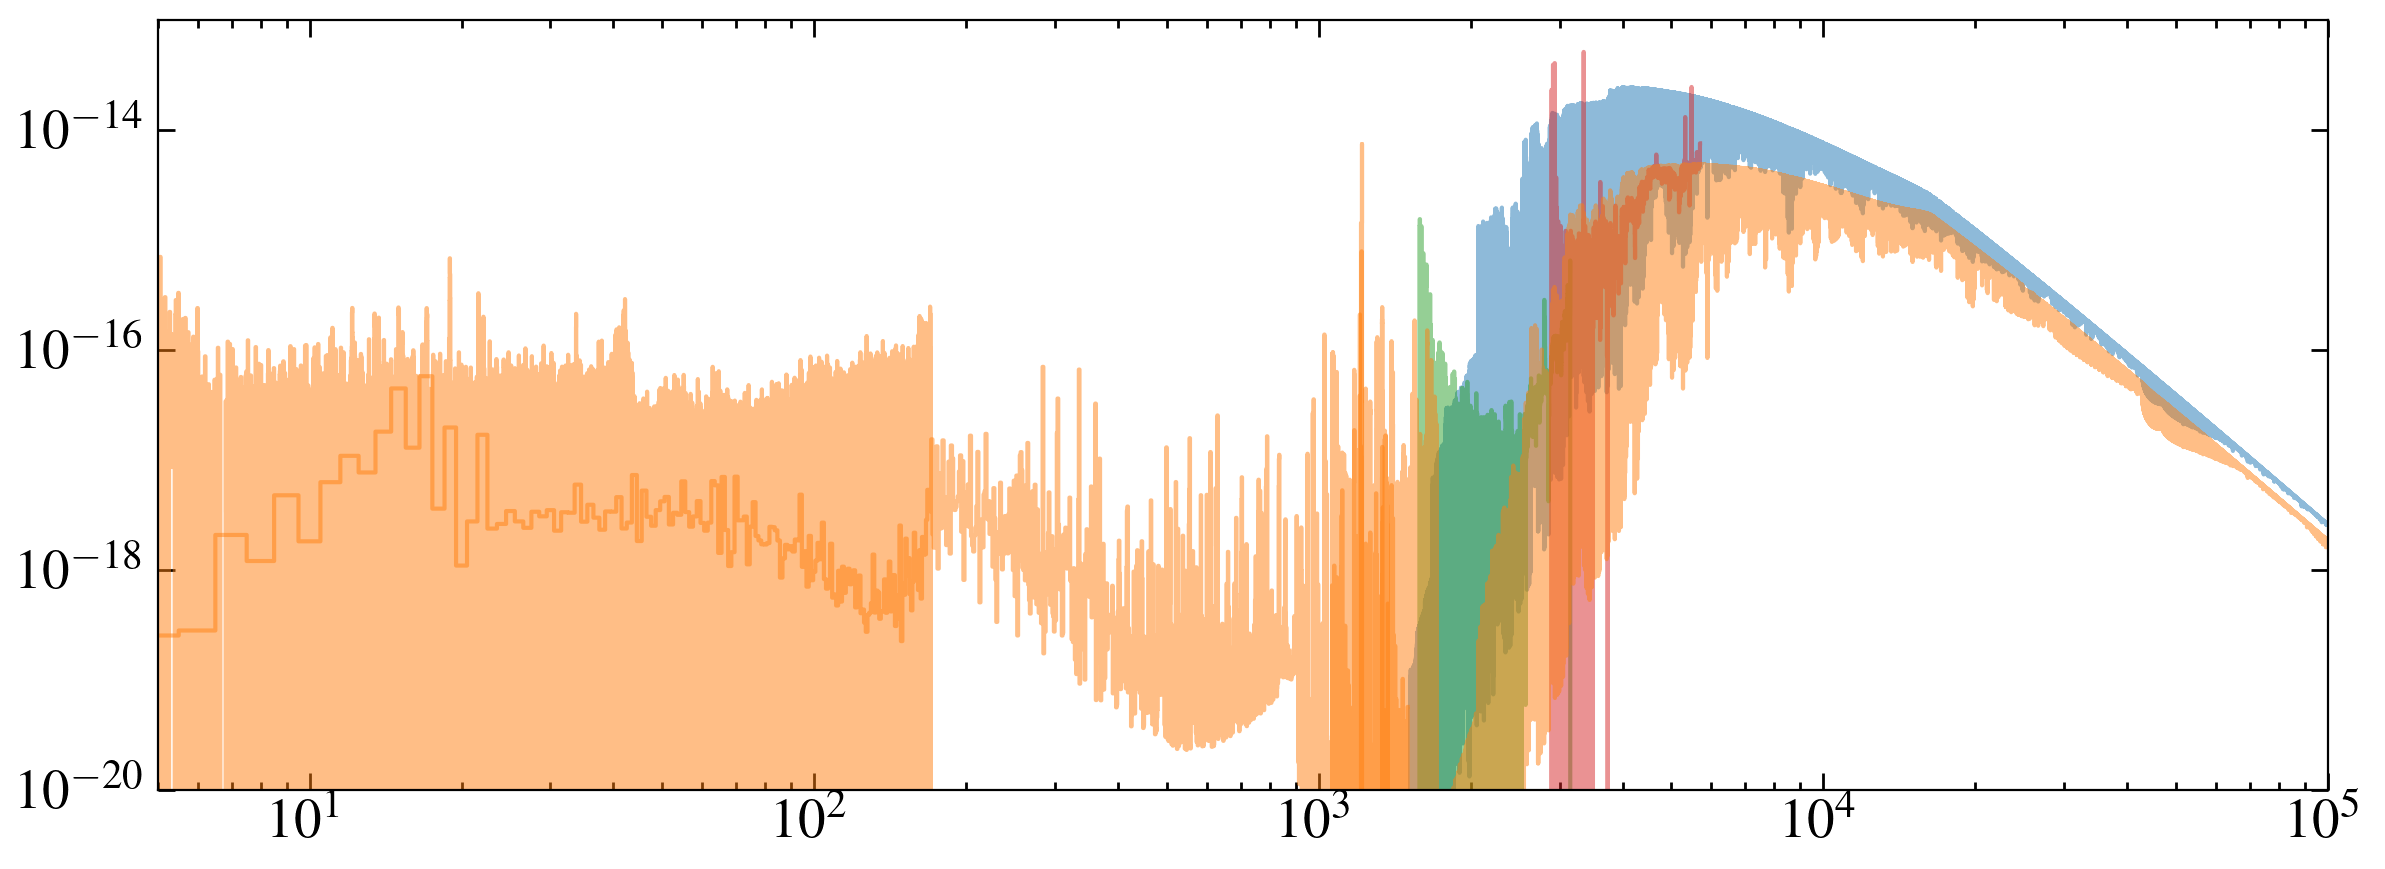

In [28]:
# fig, ax = plt.subplots()

# for spec in hlsp:
#     # if 'phx' not in spec:
#         # print(spec)
#     data = fits.getdata(spec, 1)
#     hdr = fits.getheader(spec, 0)
#     ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC'], where='mid', alpha=0.5)

# d_70 = 5.113
# scale = (d_70/distance)**2

# ax.set_yscale('log')

# ax.set_xscale('log')

# ax.set_ylim(1e-20, 1e-13)
# ax.set_xlim(5, 1e5)

# for spec in hlsp_70_oph:
#     # if 'phx' not in spec:
#         # print(spec)
#     data = fits.getdata(spec, 1)
#     hdr = fits.getheader(spec, 0)
#     ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC']*scale, where='mid', alpha=0.5, c='C1')



Distance is suspect, scale the PHX model to the G430L spectrum. Write up the Guassiuan smoother into a proper function

2.7467331466643827
4347.625


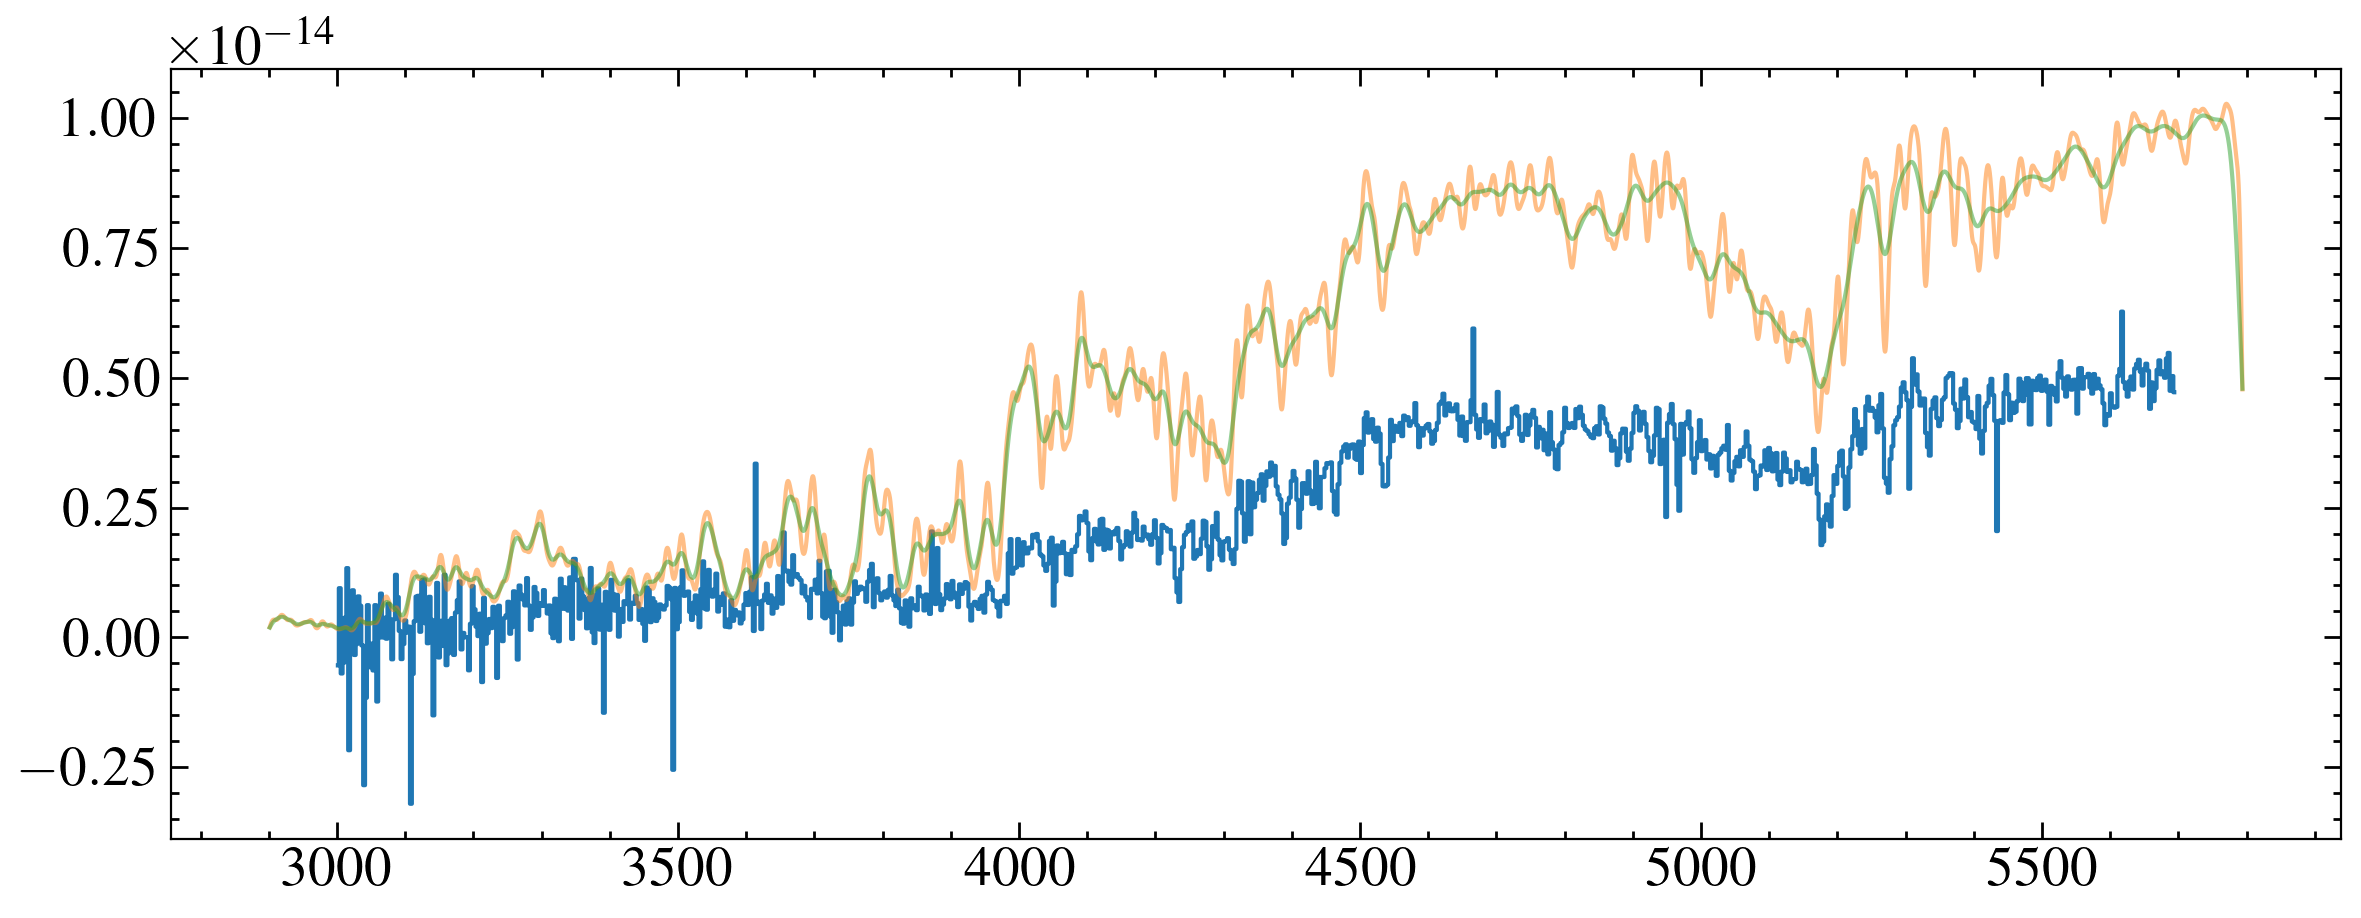

In [66]:
from astropy.convolution import convolve, Gaussian1DKernel

def guass_smooth(wavelength, flux, A = 'none', R='none', Lambda = 'none'):
    """
    Takes a spectrum and Guassian smooths it either to a angstroms per resel A or an R value. If the wavelength Lambda at which R is evaluated is not supplied it takes the central wavelength of the spectrum.   
    """
    respix = (wavelength[-1] - wavelength[0])/len(wavelength)
    if A == 'none':
        try: 
            R != 'none'
        except:
            print('Error: I need either an Angstroms per resolution element A or a resolution R = Lambda/A')
            return
        if Lambda == 'none':
            Lambda = (wavelength[-1] + wavelength[0])/2 #mid point of spectrum
            print(Lambda)
        A = Lambda / R
        # print(A)
    FWHM = A/respix 
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
    f_smooth = convolve(flux, Gaussian1DKernel(sigma))
    return f_smooth

#test smoothing phx to g430L
R = 500
A = 2.37
cenwave = 4300

fig, ax = plt.subplots()
odata = fits.getdata('draft_hlsp/ngts-10/hlsp_muscles_hst_stis_ngts-10_g430l_v1_component-spec.fits', 1)
wo, fo, eo = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
print(np.median(np.diff(ow)))

ax.step(ow, of, where='mid')
mask = (pw > ow[0]-100) & (pw < ow[-1]+100)
pwi, pfi = pw[mask], pf[mask] * normfac

# ax.plot(pwi, pfi, alpha = 0.5)

pfA = guass_smooth(pwi, pfi, A=A)
# ax.plot(pwi, pfA, alpha=0.5)

pfR = guass_smooth(pwi, pfi, R=R, Lambda=cenwave)
ax.plot(pwi, pfR, alpha=0.5)

pfL = guass_smooth(pwi, pfi, R=R)
# ax.plot(pwi, pfL, alpha=0.5)

#compare with smear
pws, pfs = pp.smear(pwi, pfi, 500)
ax.plot(pws, pfs, alpha=0.5)



#something wrong here. - listed A is angstroms per pixel, not resel. That makes more sense

3.701217133477788e-21
1.9453267699151884e-21


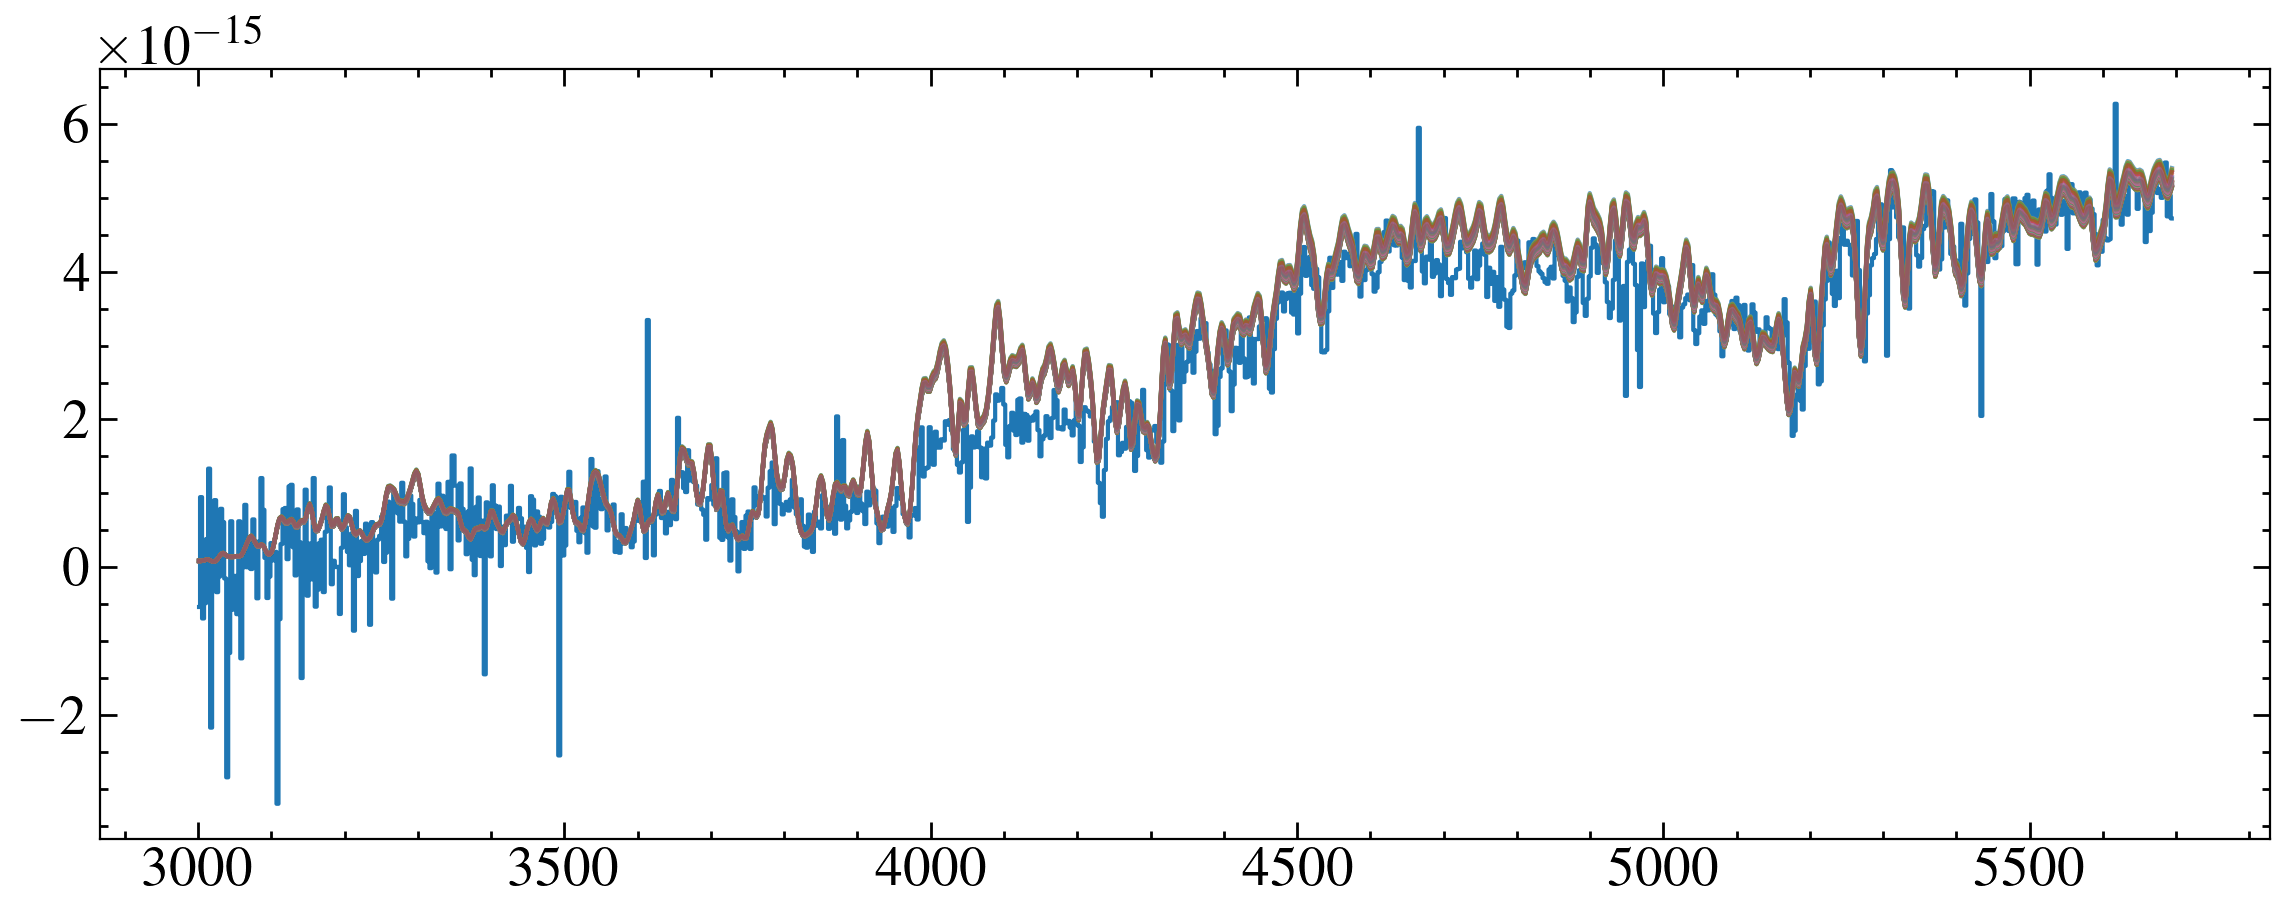

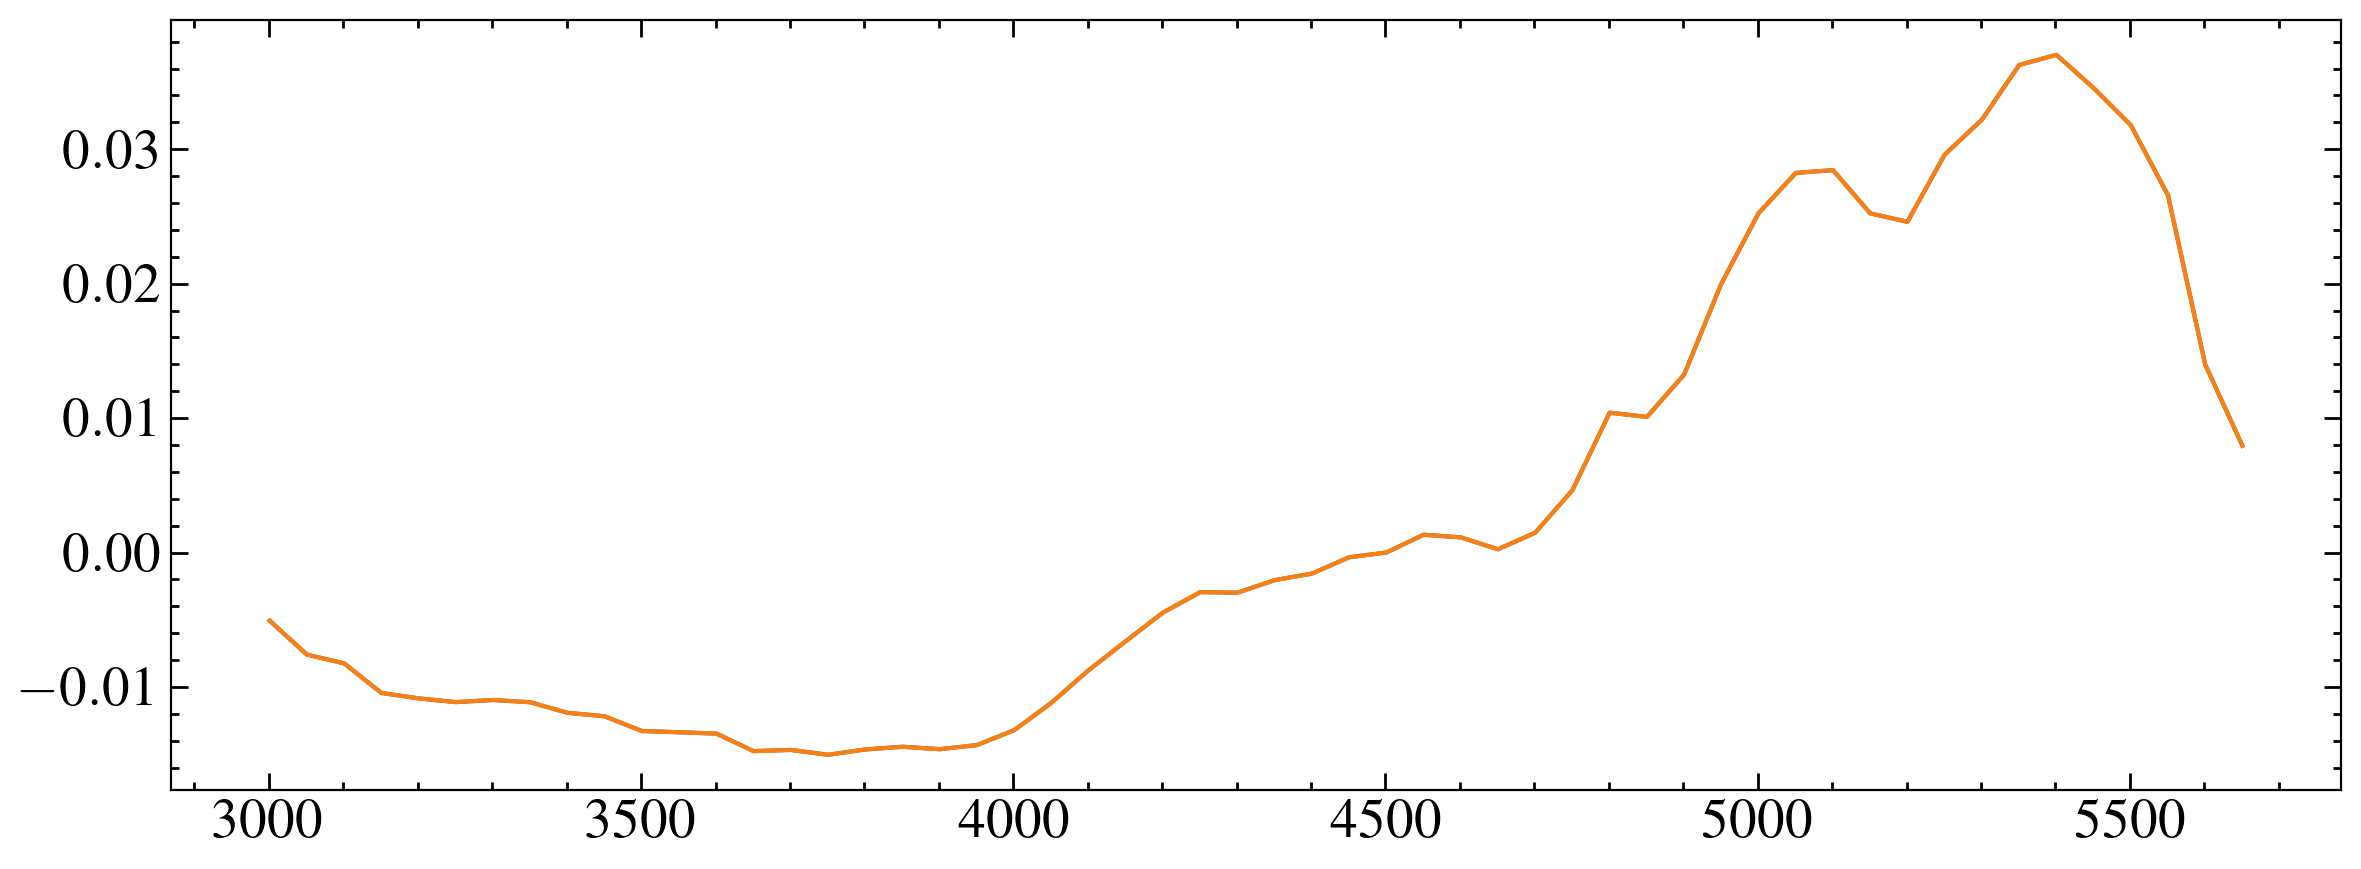

In [110]:
from scipy.optimize import leastsq

def residuals(scale, f, mf):
    return f - mf/scale
    
fig, ax = plt.subplots()


# ax.step(ow, of, where='mid')
mask = (pw > ow[0]-100) & (pw < ow[-1]+100)
pwi, pfi = pw[mask], pf[mask] 

# ax.plot(pwi, pfi, alpha = 0.5)

# pfA = guass_smooth(pwi, pfi, A=A)
# ax.plot(pwi, pfA, alpha=0.5)

pfR = guass_smooth(pwi, pfi, R=R, Lambda=cenwave)
# ax.plot(pwi, pfR, alpha=0.5)

pfR = np.interp(ow, pwi, pfR)

# ax.plot(ow, pfR)
# ax.plot(ow, pfR/of)

# ax.set_yscale('log')

# ax.set_ylim(2e20, 9e20)
redo = ext.extinguish(ow*u.AA, Ebv = 0.012)


norm_mask = ow > 4500

norm = leastsq(residuals, normfac, args=(pfR[norm_mask], (of/redo)[norm_mask]))[0][0]
print(normfac)
print(norm)

ax.step(ow, of, where='mid')
ax.plot(ow, pfR*norm)

flux_int = np.trapz(pfR*norm, ow)

starts = np.arange(ow[0], ow[-1], 50)
norms = []
fluxes = []
for start in starts:
    norm_mask = ow > start
    normi =leastsq(residuals, normfac, args=(pfR[norm_mask], (of/redo)[norm_mask]))[0][0]
    norms.append(normi)
    ax.plot(ow, pfR*normi, alpha=0.5)
    fluxi = np.trapz(pfR*normi, ow)
    fluxes.append(fluxi)
    
    


fig, ax = plt.subplots()

ax.plot(starts, (norms/norm)-1)
ax.plot(starts, (fluxes/flux_int)-1)
# ax.axhline(norm, ls='--', c='C2')
    

is the uncertainty big enought to matter?

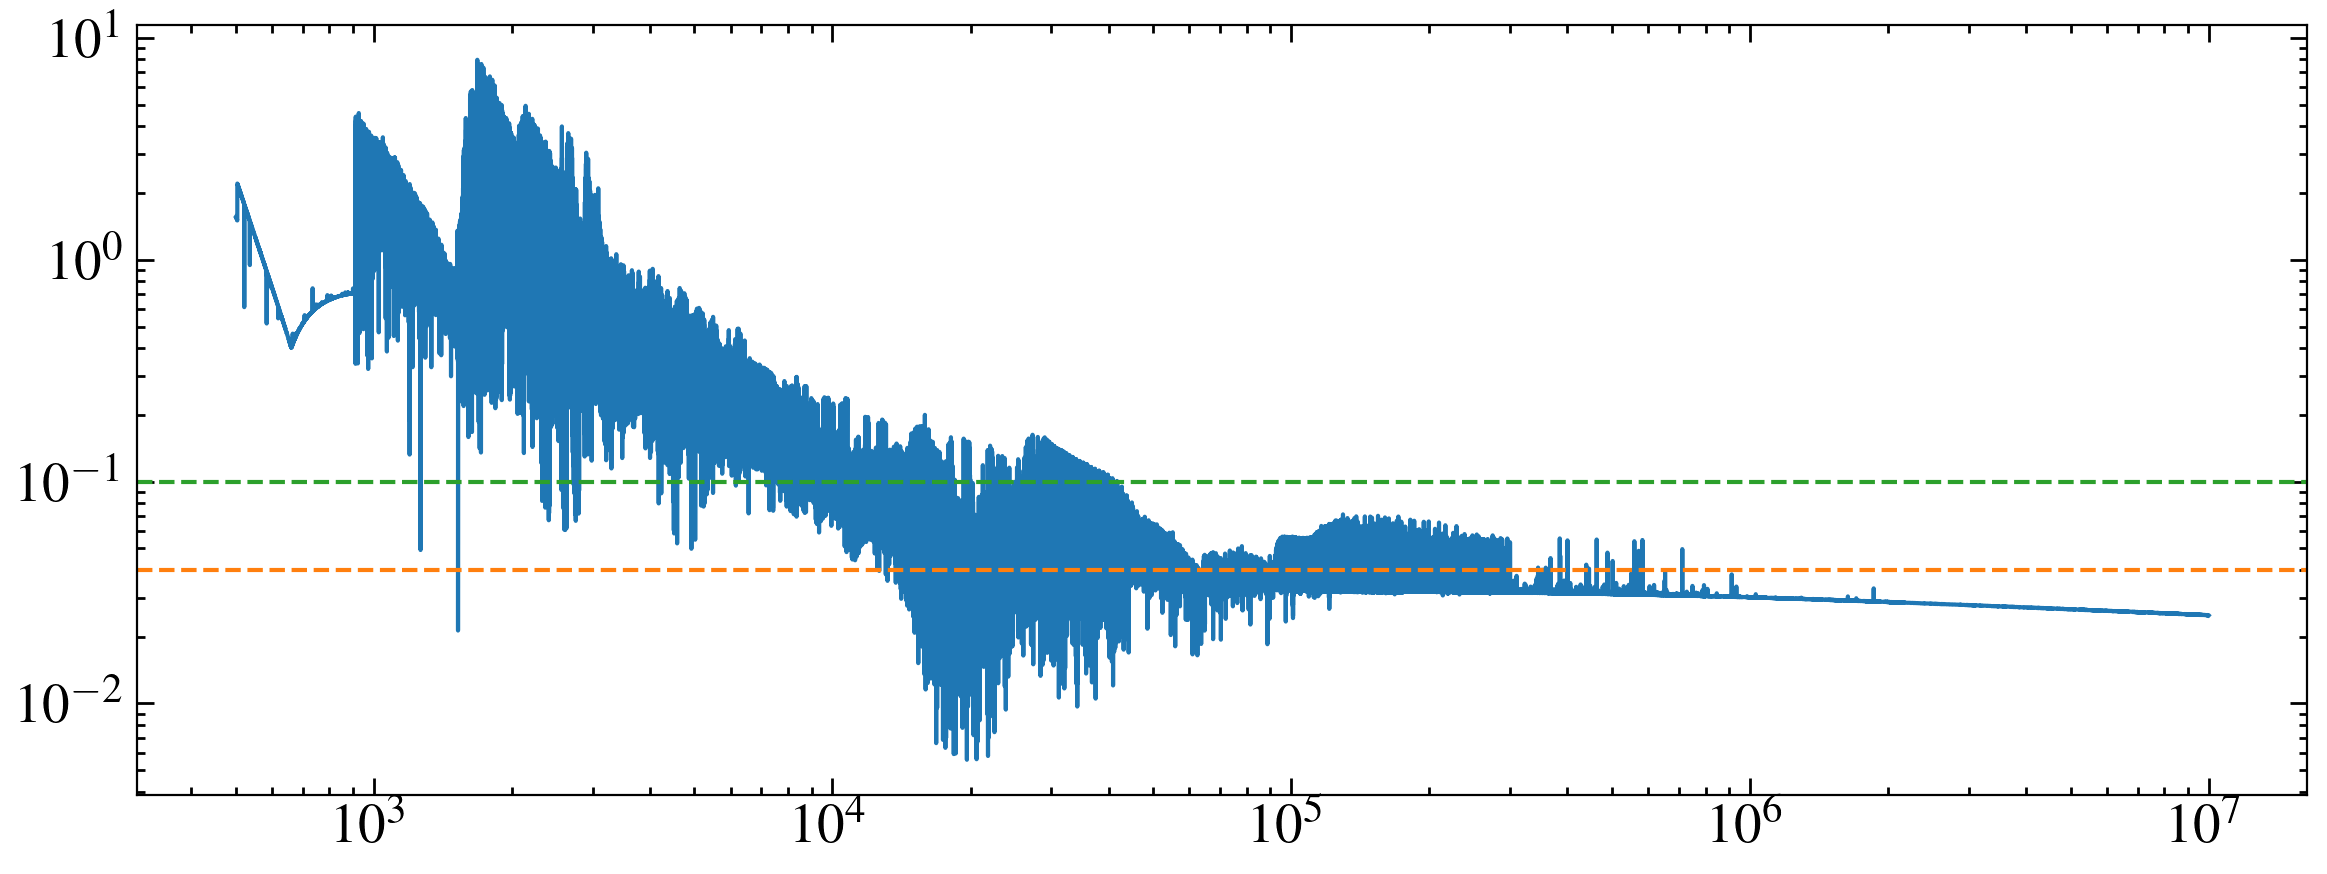

In [95]:
fig, ax = plt.subplots()

ax.plot(pw, pe/pf)
ax.set_yscale('log')
ax.set_xscale('log')

ax.axhline(0.04, ls='--', c='C1')
ax.axhline(0.1, ls='--', c='C2')

No, keep it that way. What distance do I get from norm?

In [111]:
print(distance)
dnorm = (((radius*u.Rsun).to(u.pc)**2)/norm)**0.5 
print(dnorm)

258.3044893320246
356.2935452876734 pc


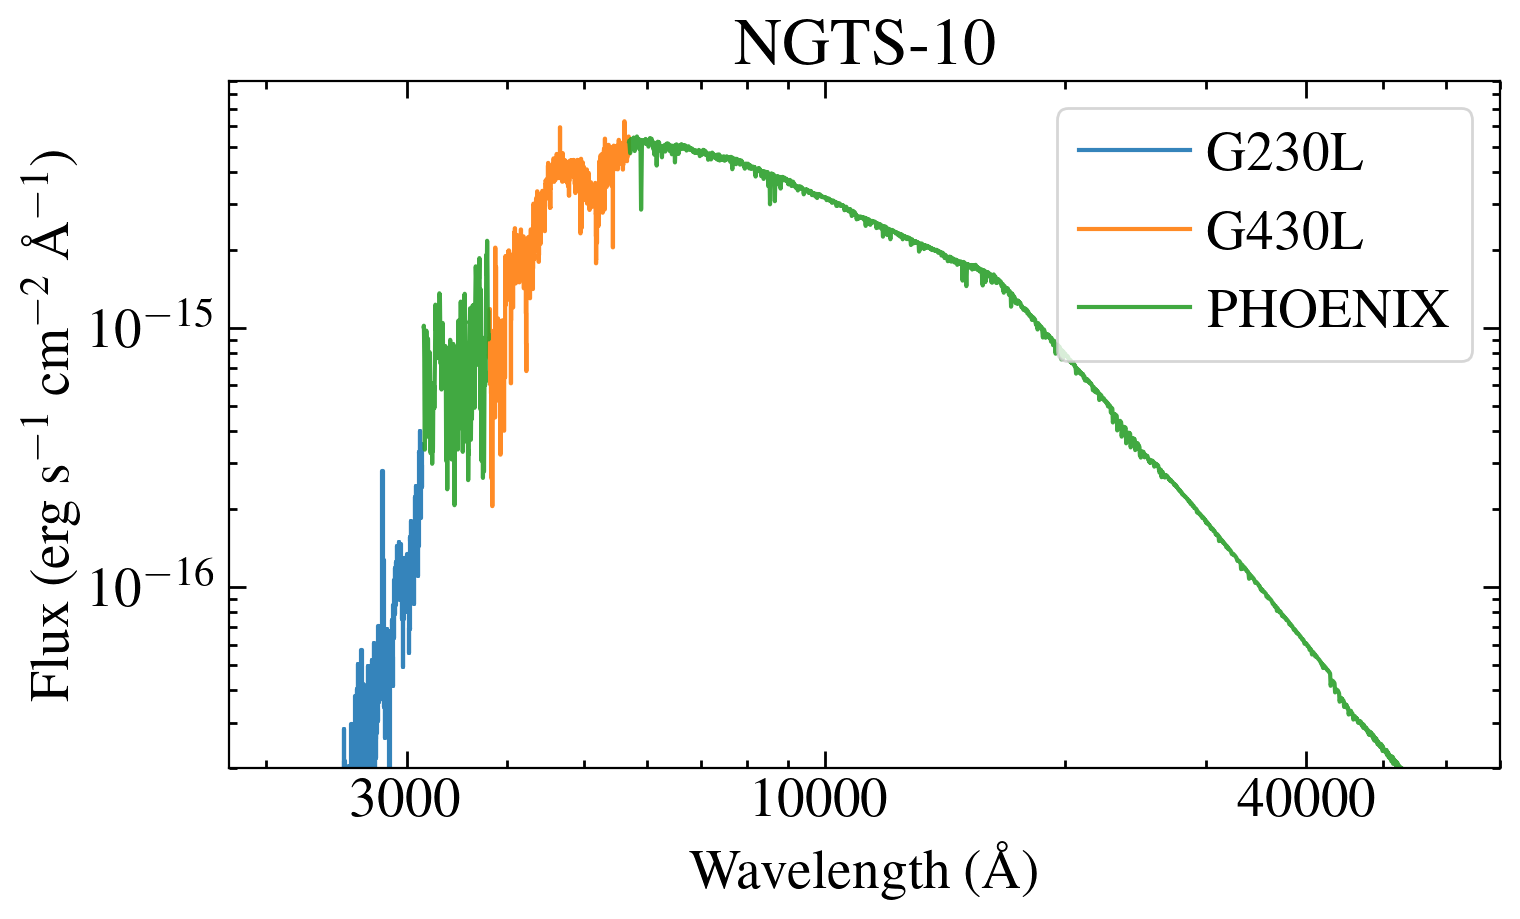

In [115]:
pwi, pfi = smear(pw, pf, 2000)
pmask = (pwi > 1800) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*norm

fig, axes = plt.subplots(figsize=(8,5))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
nmask = (nw > 2500) & (nf > 0) & (nw < 3140) 
plt.step(nw[nmask], nf[nmask], where='mid', label= 'G230L', alpha=0.9)
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow[(ow > 3800)], of[(ow > 3800)], where='mid', label='G430L', zorder=-1, alpha=0.9)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
pmask2 = (pwi > nw[-1]) & (pwi < 3800) 
plt.plot(pwi[pmask2], pfi[pmask2], label= 'PHOENIX', alpha=0.9)
pmask3 = pwi > ow[-1] 
plt.plot(pwi[pmask3], pfi[pmask3], c='C2', alpha=0.9)
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
plt.legend(frameon=True, loc=1)
plt.title('NGTS-10')
plt.xlim(1800, 70000)
plt.ylim(2e-17, 9e-15)
plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
# plt.savefig('plots/NGTS-10_ql.png', facecolor= 'w')

In [130]:
#PHX
prepare_model.make_model_spectrum('models/NGTS-10_phoenix_interpolated.ecsv', 1, sed_data, savepath = savepath, save_ecsv=False, save_fits=True, normfac=norm, model_name='PHX')


Spectrum saved as hlsp_muscles_model_phx_ngts-10_na_v1_component-spec.fits


Scale to the luminosities?

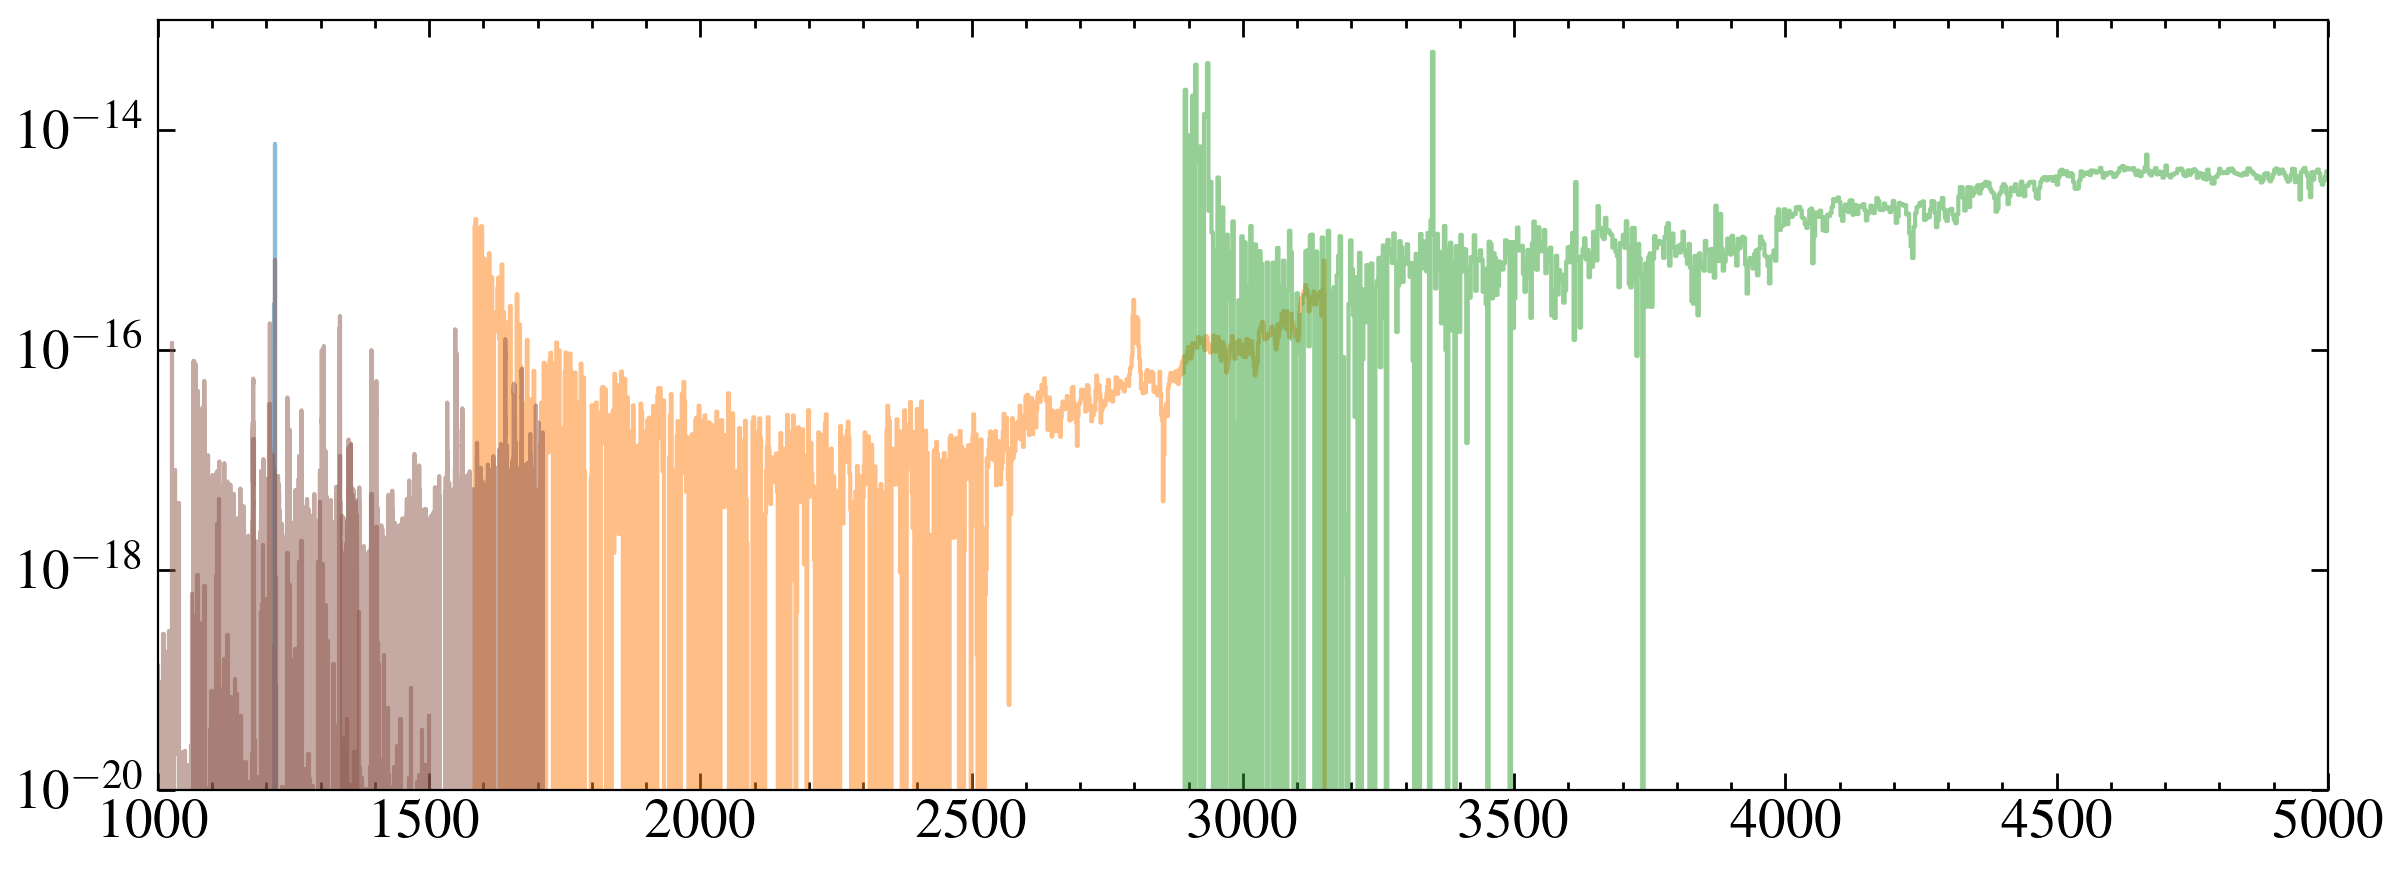

In [134]:
fig, ax = plt.subplots()

for spec in hlsp:
    data = fits.getdata(spec, 1)
    hdr = fits.getheader(spec, 0)
    # print(hdr['NORMFAC'])
        
    if 'phx' not in spec:
        # print(spec)
        ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC'], where='mid', alpha=0.5)
    # else:
    #     # print(spec)
    #     mask = (data['WAVELENGTH'] > 5000) & (data['WAVELENGTH'] < 1e5)
    #     f = guass_smooth(data['WAVELENGTH'][mask], data['FLUX'][mask], R=500, Lambda=3500)
    #     ax.step(data['WAVELENGTH'][mask], f*hdr['NORMFAC'], where='mid', alpha=0.5)
    #     # print(hdr['NORMFAC'])
        

l_ngts = 7.5068E+32 #distance independant I think
l_70 = 9.54883E+32

d_70 = 5.113*u.pc
scale = (d_70/dnorm)**2

ax.set_yscale('log')

# ax.set_xscale('log')

ax.set_ylim(1e-20, 1e-13)
# ax.set_xlim(5, 1e5)
ax.set_xlim(1000, 5000)

for spec in hlsp_70_oph:
    if 'phx' not in spec:
        # print(spec)
        data = fits.getdata(spec, 1)
        hdr = fits.getheader(spec, 0)
        ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC']*scale, where='mid', alpha=0.5, c='C5')



See if there's any meaningfull flux in the FUV/NUV overlap?

In [135]:
print(hlsp)
print(hlsp_70_oph)

['draft_hlsp/ngts-10/hlsp_muscles_model_phx_ngts-10_na_v1_component-spec.fits', 'draft_hlsp/ngts-10/hlsp_muscles_model_lya_ngts-10_na_v1_component-spec.fits', 'draft_hlsp/ngts-10/hlsp_muscles_hst_stis_ngts-10_g230l_v1_component-spec.fits', 'draft_hlsp/ngts-10/hlsp_muscles_hst_stis_ngts-10_g430l_v1_component-spec.fits']
['draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g130m_v1_component-spec.fits', 'draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits', 'draft_hlsp/70_Oph_B/hlsp_muscles_model_dem_70_oph_b_na_v1_component-spec.fits', 'draft_hlsp/70_Oph_B/hlsp_muscles_model_phx_70_oph_b_na_v1_component-spec.fits', 'draft_hlsp/70_Oph_B/hlsp_muscles_cxo_hrc_70_oph_b_none_v1_component-spec.fits']


In [181]:
ndata = fits.getdata(hlsp[2], 1)
fdata = fits.getdata(hlsp_70_oph[1], 1)

nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']


# fig, ax = plt.subplots()

# ax.step(nw, nf, where='mid')
# ax.step(nw, ne, where='mid', alpha=0.5)
# ax.step(fw, ff*scale, where='mid')
# ax.step(fw, fe*scale, where='mid', alpha=0.5)

# ax.set_xlim(1500, 1800)
# # ax.set_ylim(0)
# ax.set_yscale('log')

# mask = nw < fw[-1]
# nint = np.trapz(nf[mask], nw[mask])
# print(nint)

# #nope
print(nw[0], fw[-1] )

1567.4267445730788 1718.493248365018


In [149]:
#apparently the Gmags are reliable
Gmag_ngts = 14.314493
Gmag_70 = 5.5392

mag_scale = 2.512**(Gmag_70-Gmag_ngts)
print(scale)
print(mag_scale)

0.00020593761377310442
0.0003088236108478444


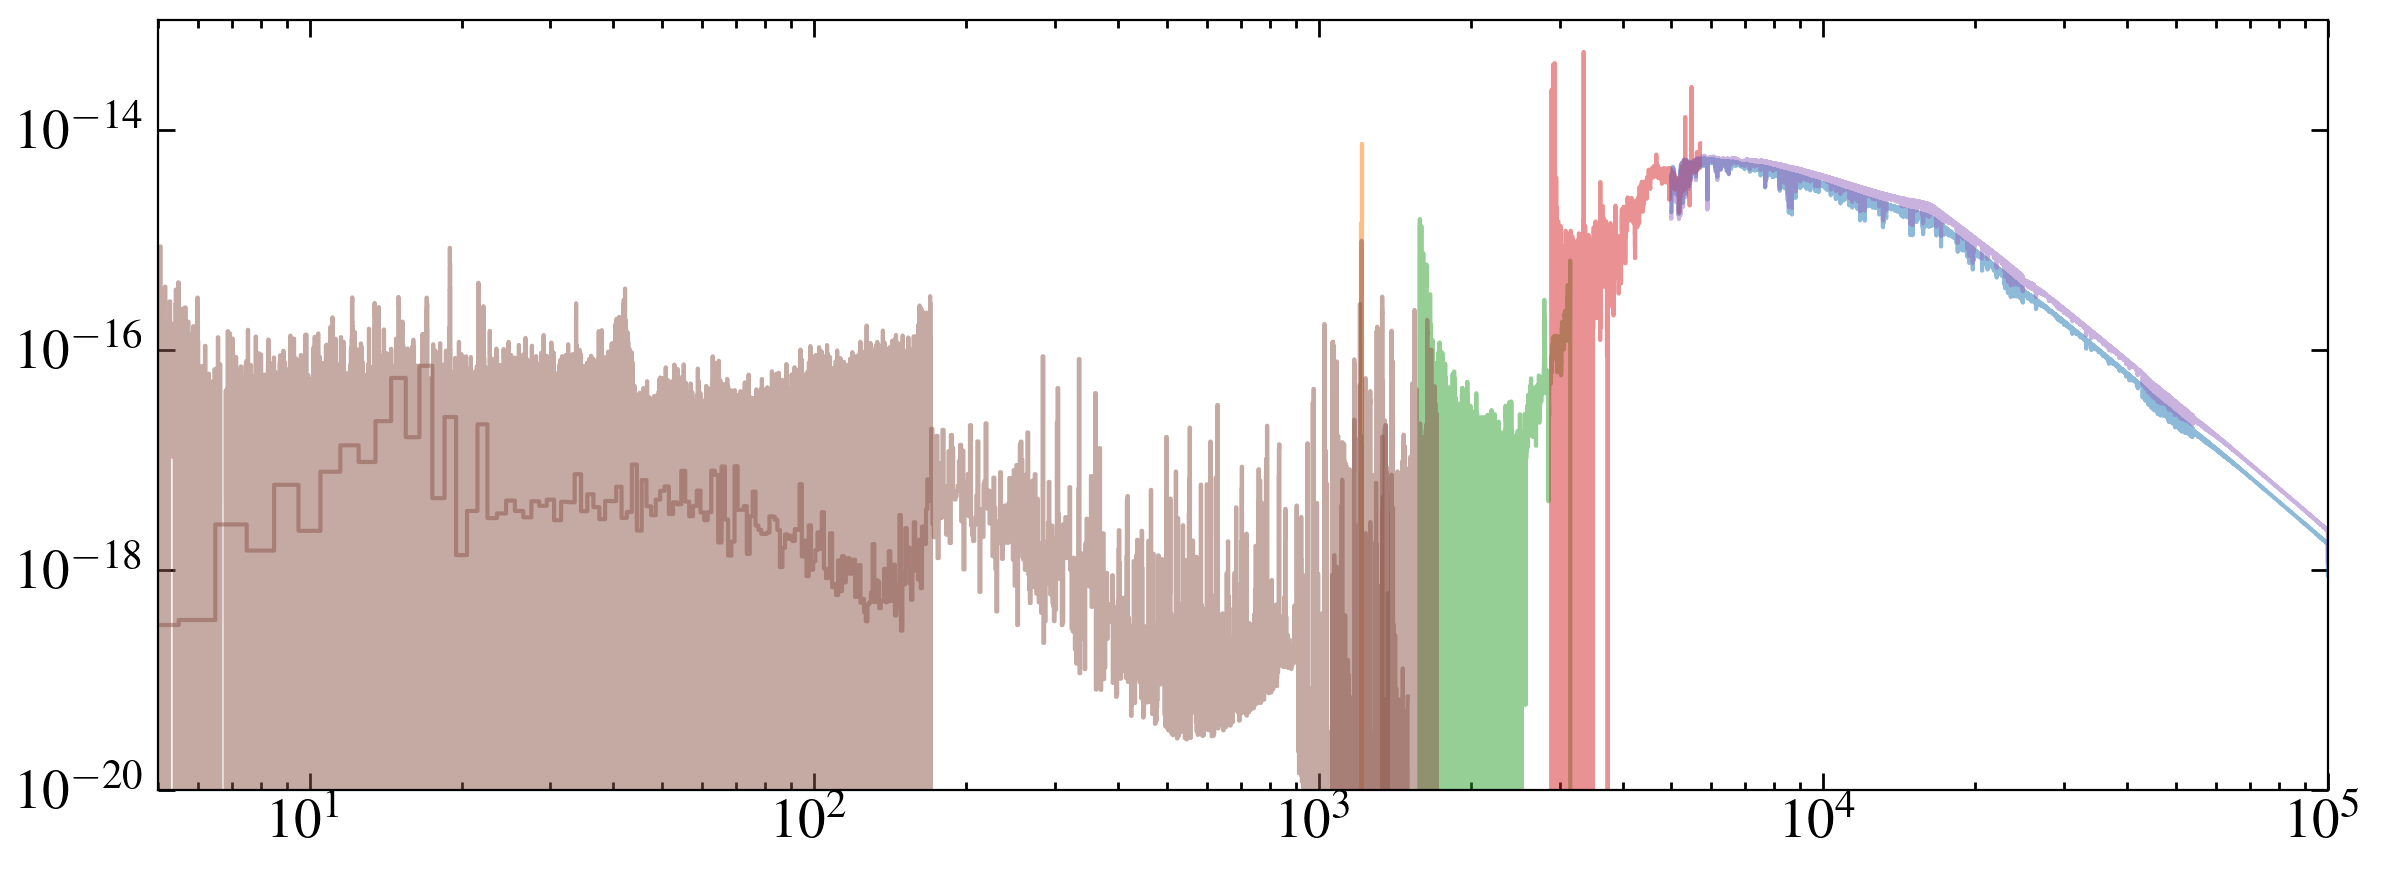

In [154]:
fig, ax = plt.subplots()

for spec in hlsp:
    data = fits.getdata(spec, 1)
    hdr = fits.getheader(spec, 0)
    # print(hdr['NORMFAC'])
        
    if 'phx' not in spec:
        # print(spec)
        ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC'], where='mid', alpha=0.5)
    else:
    #     # print(spec)
        mask = (data['WAVELENGTH'] > 5000) & (data['WAVELENGTH'] < 1e5)
        f = guass_smooth(data['WAVELENGTH'][mask], data['FLUX'][mask], R=500, Lambda=3500)
        ax.step(data['WAVELENGTH'][mask], f*hdr['NORMFAC'], where='mid', alpha=0.5)
    #     # print(hdr['NORMFAC'])
        

l_ngts = 7.5068E+32 #distance independant I think
l_70 = 9.54883E+32

d_70 = 5.113*u.pc
scale = (d_70/dnorm)**2

ax.set_yscale('log')

ax.set_xscale('log')

ax.set_ylim(1e-20, 1e-13)
ax.set_xlim(5, 1e5)
# ax.set_xlim(1000, 5000)

for spec in hlsp_70_oph:
    data = fits.getdata(spec, 1)
    hdr = fits.getheader(spec, 0)
    if 'phx' not in spec:
        # print(spec)
        
        ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC']*mag_scale, where='mid', alpha=0.5, c='C5')
    else:
        mask = (data['WAVELENGTH'] > 5000) & (data['WAVELENGTH'] < 1e5)
        f = guass_smooth(data['WAVELENGTH'][mask], data['FLUX'][mask], R=500, Lambda=3500)
        ax.step(data['WAVELENGTH'][mask], f*hdr['NORMFAC']*mag_scale, where='mid', alpha=0.5)
   



I think that's the best compromise with the data we have.

In [162]:
list(hdr.keys())

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'EXTEND',
 'TELESCOP',
 'INSTRUME',
 'GRATING',
 'DETECTOR',
 'FILTER',
 'TARGNAME',
 'RA_TARG',
 'DEC_TARG',
 'PROPOSID',
 'HLSPNAME',
 'HLSPACRN',
 'HLSPLEAD',
 'PR_INV_L',
 'PR_INV_F',
 'DATE-OBS',
 'EXPSTART',
 'EXPEND',
 'EXPTIME',
 'EXPDEFN',
 'EXPMIN',
 'EXPMAX',
 'EXPMED',
 'NORMFAC',
 'WAVEMIN',
 'WAVEMAX',
 'WAVEUNIT',
 'AIRORVAC',
 'SPECRES',
 'WAVERES',
 'FLUXMIN',
 'FLUXMAX',
 'FLUXUNIT']

In [164]:
starspec = fits.getdata('fixed_hlsp/ngts-10/hlsp_muscles_multi_multi_ngts-10_broadband_v25_adapt-const-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']
sol = Table.read('Solar_1au_sed.ecsv')
sw, sf = sol['WAVELENGTH'], sol['FLUX']

In [169]:
const.L_sun.to(u.erg/u.s)

<Quantity 3.828e+33 erg / s>

-0.7075170837797071


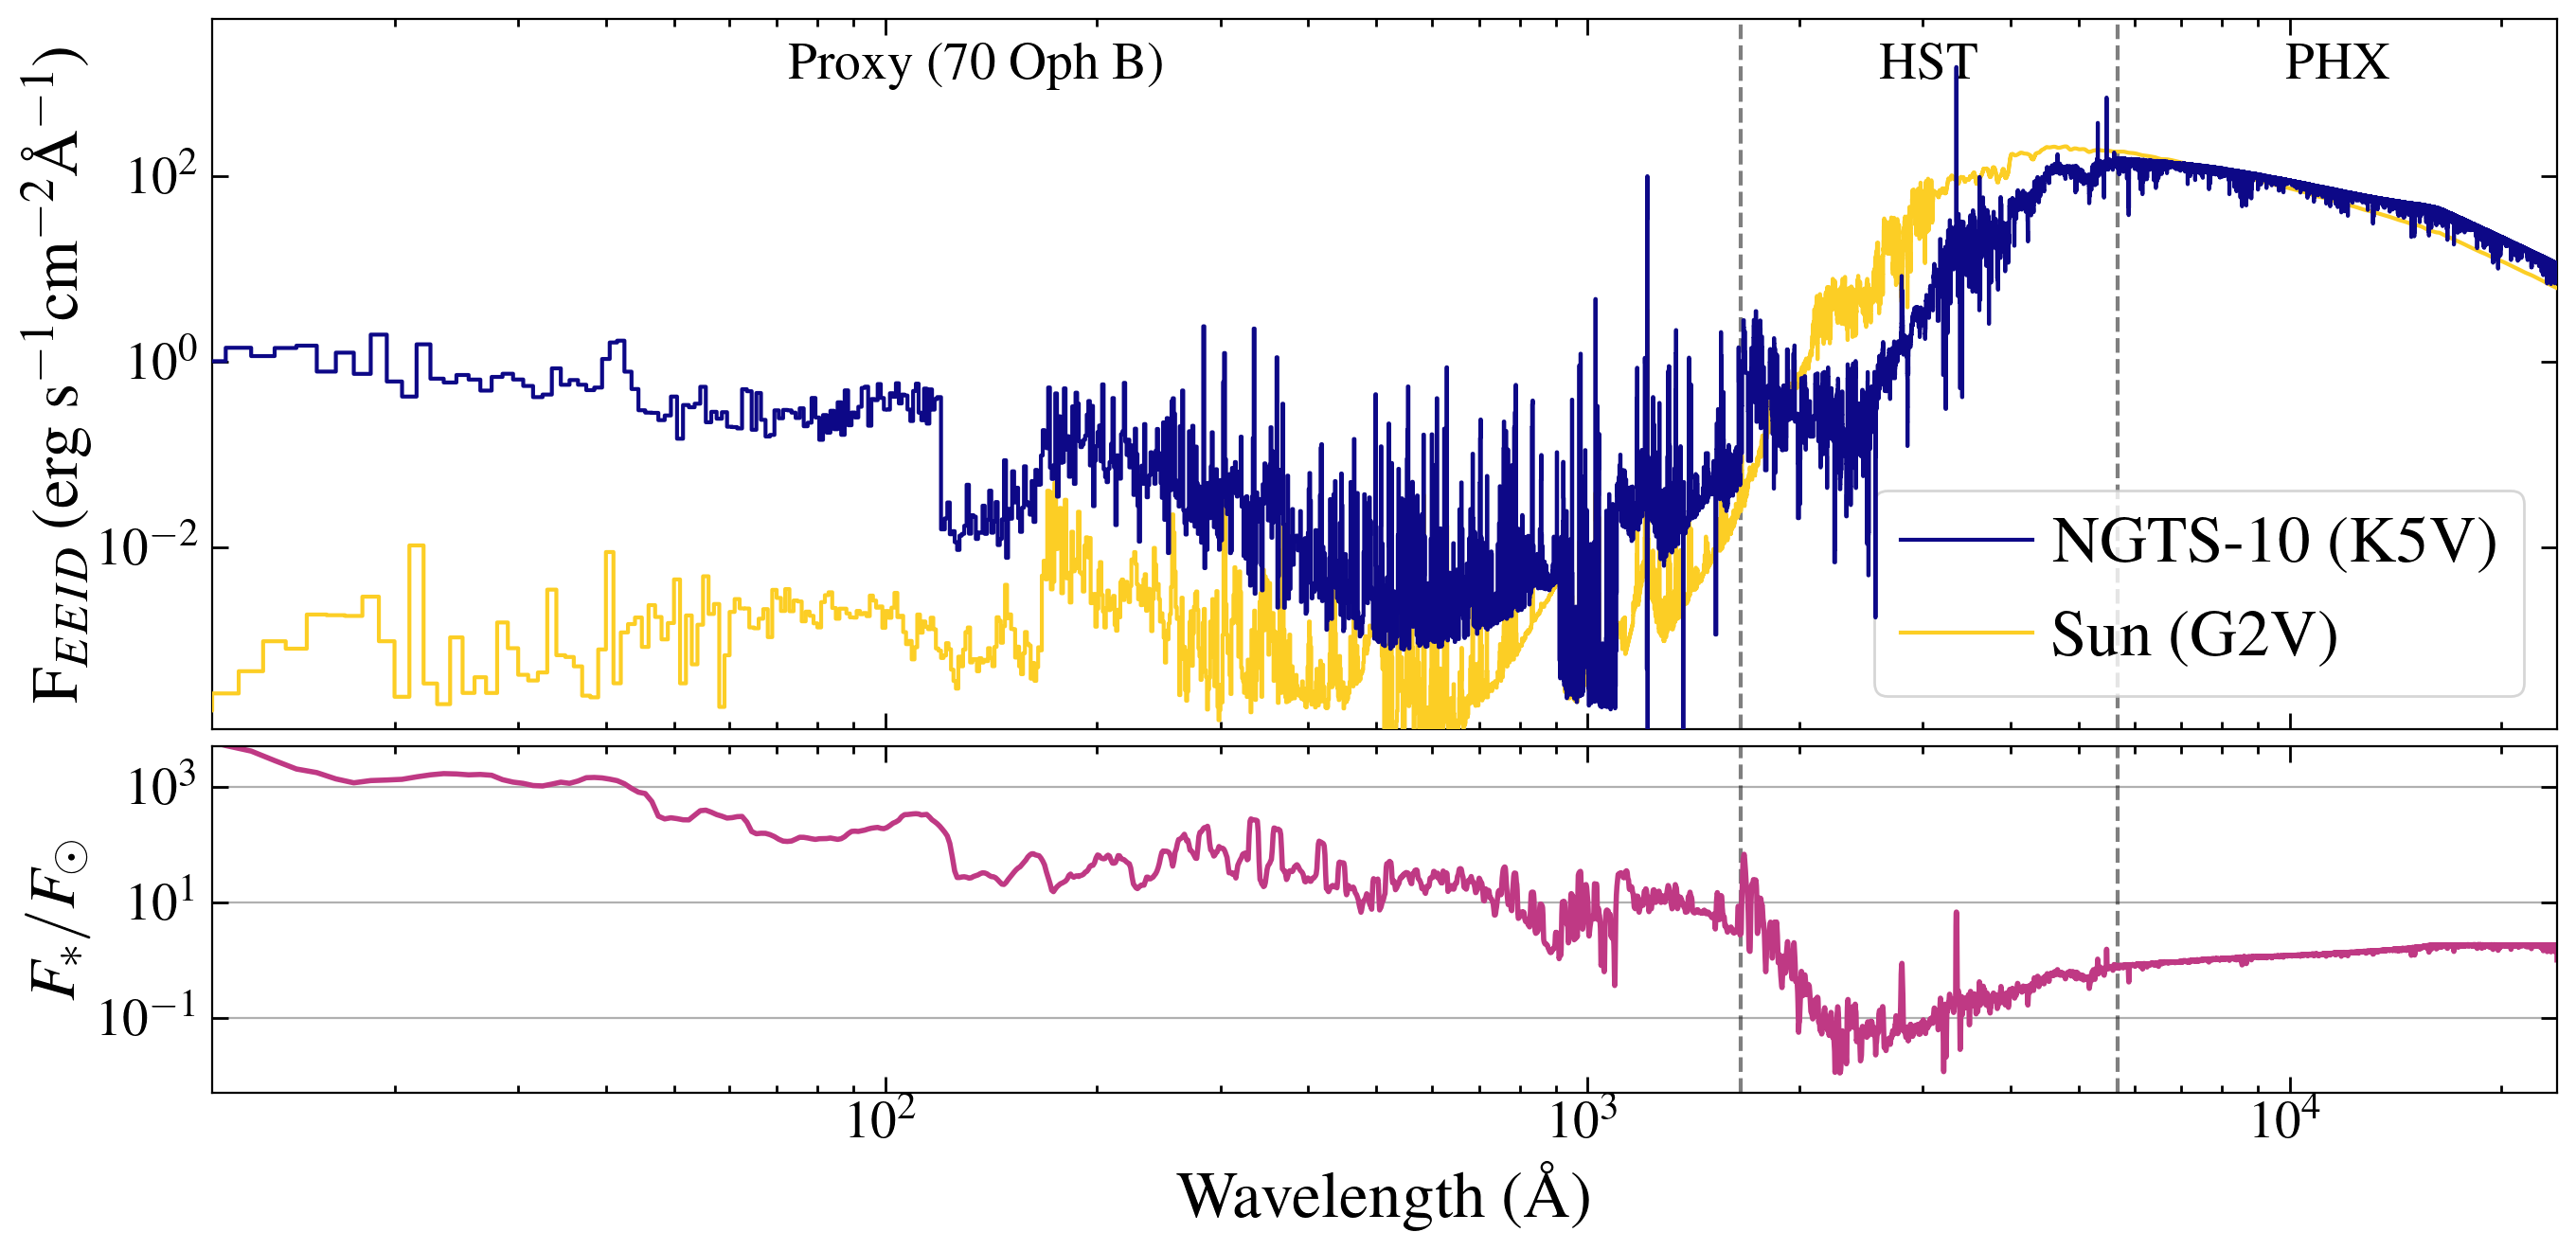

In [176]:

# cols = ['C0', 'C1', 'C2']
cols = [plt.cm.plasma(0),plt.cm.plasma(0.9), plt.cm.plasma(0.45)]

dstar = dnorm
dsun = 1*u.au
lstar = 10**-0.6590

lstar = (7.5068e32*u.erg/u.s).to(u.Lsun).value
print(np.log10(lstar))
eeidau = (lstar**0.5)*1*u.au

solscale = lstar*(dsun.to(u.m)/dstar.to(u.m))**2
starscale = ((dstar.to(u.m))/(eeidau.to(u.m)))**2

fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0],[1,1,1]],figsize=(14, 7), sharex=True)


ax= axes[0]
ax.step(starw, starf*starscale, c=cols[0], label = 'NGTS-10 (K5V)', zorder=12, where='mid')
ax.step(sw, sf, c=cols[1], label = 'Sun (G2V)', zorder=10, where='mid')
# ax.set_xlim(11, sw[-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.1e-4, 4.9e3)

bar_y = 1e3
label_y = bar_y*1.5
e_y = bar_y *0.3

xlims = (11, sw[-1])
ax.set_xlim(xlims[0], xlims[1])
divlines = (1650, 5690)
[ax.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]

labels = ['Proxy (70 Oph B)', 'HST', 'PHX']
labpos = np.sort(np.hstack((xlims, divlines)))

for i, label in enumerate(labels):
    label_x = (labpos[i]*labpos[i+1])**0.5
    ax.annotate(label, (label_x, label_y), ha='center', va='center')



ax.legend(fontsize=25, loc=4,frameon=True)
ax.set_ylabel('F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)

ax1 = axes[1]
ax1.set_xlabel('Wavelength (\AA)', size=25)
[ax1.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]


mask = (starw> sw[0]) & (starw < sw[-1])
fnew = interp1d(starw[mask], starf[mask], fill_value='extrapolate')(sw)
fnew = fnew*starscale.value
ratio = fnew/sf
ratio = convolve(ratio,Box1DKernel(10))
ax1.plot(sw, ratio, c=cols[2], lw=2)
# ax1.set_ylim(0, 1000)

ax1.set_yscale('log')
ax1.set_ylim(5e-3, 5e3)
ax1.set_ylabel('$F_*/F_{\odot}$', size=25)
# ax1.axhline(1, ls='--', c='k', alpha=0.5)

ax1.grid(axis='y')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


plt.savefig('plots/ngts-10_v_sun.pdf')

# add the old eps_ind spec
# data = Table.read('/home/david/work/hwo/seds/eps_ind_sed_v01.txt', format='ascii.basic')
# oldw, oldf = np.loadtxt('/home/david/work/hwo/seds/eps_ind_sed_v01.txt', unpack=True)
# ax.step(oldw, oldf*starscale, c='C2', zorder=20)

In [178]:
p = 3.8713694898542497e-3
pe = 0.1759164e-3

print(1/p)
print(pe/p**2)



258.3065250218853
11.737539931914567


In [180]:
dnorm

<Quantity 356.29354529 pc>